In [1]:
# imports

import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
from astropy import units as u
from numpy import ma
import numpy as np
from astropy.table import Table, Column, MaskedColumn, pprint
from astropy.io import fits
from astropy.wcs import WCS
from scipy import integrate
from astropy.coordinates import SkyCoord


# Imports necessary for Source Catalog
from photutils.background import Background2D, MedianBackground
from astropy.convolution import convolve
from photutils.segmentation import make_2dgaussian_kernel
from photutils.segmentation import detect_sources
from photutils.segmentation import deblend_sources
from photutils.segmentation import SourceFinder
from photutils.segmentation import SourceCatalog
from scipy import ndimage
from scipy.ndimage import binary_erosion
from numpy import loadtxt
from photutils.aperture import CircularAperture, aperture_photometry, EllipticalAperture
from astropy.coordinates import match_coordinates_sky

# Imports necessary for visulisation
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.visualization import simple_norm


from astropy.io import fits
from astropy.wcs import WCS
from astropy.nddata import Cutout2D
from astropy.convolution import convolve, Moffat2DKernel
import matplotlib.pyplot as plt
import numpy as np
from mpdaf.obj import Cube, Image

# Imports for cutouts and convolution

from astropy.io import fits
from astropy.wcs import WCS
from astropy.nddata import Cutout2D
from astropy.convolution import convolve, Moffat2DKernel
import matplotlib.pyplot as plt
import numpy as np
from mpdaf.obj import Cube, Image
import os


In [2]:
def crossmatch_catalogs_radec(catalog1, catalog2, tolerance_arcsec=1.0):
    """
    Crossmatch two catalogs of sources based on their RA and Dec coordinates.

    Parameters
    ----------
    catalog1 : astropy.table.Table - is it or do I need to convert it to this?
        The first catalog of sources.
    
    catalog2 : astropy.table.Table
        The second catalog of sources.

    tolerance_arcsec : float
        The matching tolerance in arcseconds. Default is 1.0.

    Returns
    -------
    matched_catalog : astropy.table.Table
        A new catalog with only the matched sources.
    
    """
   
    
   # Extract RA and Dec with case-insensitive column names
    ra1 = catalog1[[col for col in catalog1.dtype.names if col.lower() == 'ra'][0]]
    dec1 = catalog1[[col for col in catalog1.dtype.names if col.lower() == 'dec'][0]]

    ra2 = catalog2[[col for col in catalog2.dtype.names if col.lower() == 'ra'][0]]
    dec2 = catalog2[[col for col in catalog2.dtype.names if col.lower() == 'dec'][0]]

    
    # Create SkyCoord objects
    coords1 = SkyCoord(ra1, dec1, unit='deg')
    coords2 = SkyCoord(ra2, dec2, unit='deg')
    
    # Perform the crossmatch
    idx, d2d, d3d = match_coordinates_sky(coords1, coords2)
    
    # Convert tolerance to degrees
    tolerance = tolerance_arcsec * u.arcsec
    
    # Find matches within the specified tolerance
    matched_mask = d2d <= tolerance
    
    # Get the indices of matched sources in catalog1 and catalog2
    idx1 = np.arange(len(catalog1))[matched_mask]
    idx2 = idx[matched_mask]
    
    # Extract the matched rows from both catalogs
    matched_catalog1 = catalog1[matched_mask]
    matched_catalog2 = catalog2[idx2]

    # Create a new structured array with combined columns from both catalogs
    # Prefix field names from each catalog to ensure uniqueness
    combined_dtype = [(f'cat1_{name}', dtype) for name, dtype in matched_catalog1.dtype.descr]
    combined_dtype += [(f'cat2_{name}', dtype) for name, dtype in matched_catalog2.dtype.descr if f'cat2_{name}' not in combined_dtype]

    combined_catalog = np.empty(matched_catalog1.shape, dtype=combined_dtype)

    # Fill the new structured array with data from both matched catalogs
    # Use the prefixed field names
    for name in matched_catalog1.dtype.names:
        combined_catalog[f'cat1_{name}'] = matched_catalog1[name]
    for name in matched_catalog2.dtype.names:
        combined_catalog[f'cat2_{name}'] = matched_catalog2[name]

    matched_catalog = Table(combined_catalog)

    # Print the column names
    #print("Columns in matched catalog:")
    #for colname in matched_catalog.colnames:
        #print(colname)

    return matched_catalog



def crossmatch_catalogs_ID(catalog1, catalog2):
    """
    Crossmatch two catalogs of sources based on their ID.

    Parameters
    ----------
    catalog1 : numpy.recarray or astropy.table.Table
        The first catalog of sources.
    
    catalog2 : numpy.recarray or astropy.table.Table
        The second catalog of sources.

    Returns
    -------
    matched_catalog : astropy.table.Table
        A new catalog with only the matched sources.
    
    Raises
    ------
    ValueError
        If the 'ID' column is not found in either catalog.
    """
    
    # Handle both astropy Table and numpy recarray
    if isinstance(catalog1, Table):
        colnames1 = catalog1.colnames
    else:
        colnames1 = catalog1.dtype.names
    
    if isinstance(catalog2, Table):
        colnames2 = catalog2.colnames
    else:
        colnames2 = catalog2.dtype.names
    
    # Extract ID from each catalog
    try:
        ID1 = catalog1[[col for col in colnames1 if col.lower() == 'id'][0]]
    except IndexError:
        raise ValueError("The first catalog does not have an 'ID' column.")
    
    try:
        ID2 = catalog2[[col for col in colnames2 if col.lower() == 'id'][0]]
    except IndexError:
        raise ValueError("The second catalog does not have an 'ID' column.")
    
    # Perform the crossmatch of ID columns
    idx = np.where(np.in1d(ID1, ID2))[0]

    # Extract the matched rows from both catalogs
    matched_catalog1 = catalog1[idx]
    matched_catalog2 = catalog2[idx]

    # Remove the ID column from the second matched catalog to avoid duplication
    matched_catalog2 = matched_catalog2[[col for col in matched_catalog2.dtype.names if col.lower() != 'id']]

    # Create a new structured array with combined columns from both catalogs
    combined_dtype = [(f'{name}', dtype) for name, dtype in matched_catalog1.dtype.descr]
    combined_dtype += [(f'{name}', dtype) for name, dtype in matched_catalog2.dtype.descr]

    # Use len(matched_catalog1) instead of matched_catalog1.shape
    combined_catalog = np.empty(len(matched_catalog1), dtype=combined_dtype)

    # Fill the new structured array with data from both matched catalogs
    for name in matched_catalog1.dtype.names:
        combined_catalog[f'{name}'] = matched_catalog1[name]
    for name in matched_catalog2.dtype.names:
        combined_catalog[f'{name}'] = matched_catalog2[name]

    matched_catalog = Table(combined_catalog)

    return matched_catalog




In [79]:
# Practice on one source 

filepath = '/Users/s2537809/Downloads/jades-gds-wide2-v3_prism-clear_1180_105840.spec.fits'

tab = Table.read(filepath, format='fits')

tab

wave,flux,err,sky,path_corr,npix,norm_corr,flux_sum,profile_sum,var_sum
um,uJy,uJy,uJy,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.58,--,--,--,--,0.0,--,0.0,0.0,0.0
0.5836851085753291,--,--,--,--,0.0,--,0.0,0.0,0.0
0.5874378771811705,--,--,--,--,0.0,--,0.0,0.0,0.0
0.591260215571612,--,--,--,--,0.0,--,0.0,0.0,0.0
0.5951542612478814,--,--,--,--,0.0,--,0.0,0.0,0.0
0.5991219350103587,--,--,--,--,0.0,--,0.0,0.0,0.0
0.6031652486825945,-0.06287312187755979,0.031081227872284494,0.005569380851794653,1.2490045579250768,9.0,0.9938756539447828,-0.016783936503509476,1.6232669405298117,0.0057566509133002985
0.6072866429848921,-0.04512899752161912,0.025874233011865228,0.005285534362540315,1.2501859229492622,15.0,0.9947482718453647,-0.09409414335592332,2.4712883688646152,0.0088412597855403


In [3]:


# Define the file path
file_path_1 = '/Users/s2537809/MUSE/primer_f356w_det_cat_local_ferr_ecorr_jels_area 2.fits'

    

# Load the catalog
cat1 = Table.read(file_path_1, format='fits')

# Display the catalog
cat1



#z6_cat = cat[(cat['zmed_all'] >= 5.5) &(cat['zmed_all'] <= 6.5)]

#print(len(z6_cat))

<Table length=34912>
  ID      X_IMAGE      ... NIRCam_F470N_APER_2_as_magerr_corr
int64     float64      ...              float64              
----- ---------------- ... ----------------------------------
12835 10141.1416015625 ...                              -99.0
13026  10444.349609375 ...                              -99.0
13038 10211.8369140625 ...                  2.662973642349243
13048 10097.1943359375 ...                                 --
13068   10121.02734375 ...                                 --
13083 10240.1845703125 ...                  8.946840286254883
13121   10339.90234375 ...                              -99.0
13136  10169.810546875 ...                  29.05215072631836
13137 10232.0478515625 ...                 2.1077356338500977
13165   10309.21484375 ...                              -99.0
  ...              ... ...                                ...
71595 13795.5576171875 ...                  3.903977394104004
71596   13973.44140625 ...                              -99.0
71597    15444.3828125 ...                              -99.0
71598         12954.25 ...                  6.474359035491943
71599     9581.2578125 ...                0.14311346411705017
71600  10068.044921875 ...                              -99.0
71601  10904.458984375 ...                 0.8079209923744202
71602  14522.134765625 ...                              -99.0
71603   10100.50390625 ...                              -99.0
71606  9713.5595703125 ...                 0.6218782663345337

In [27]:

filepath = '/Users/s2537809/Downloads/borg-0314m6712-v3_prism-clear_1747_449.spec.fits'

tab = Table.read(filepath, format='fits')

tab

wave,flux,err,sky,path_corr,npix,norm_corr,flux_sum,profile_sum,var_sum
um,uJy,uJy,uJy,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.58,--,--,--,--,0.0,--,0.0,0.0,0.0
0.5836851085753291,--,--,--,--,0.0,--,0.0,0.0,0.0
0.5874378771811705,--,--,--,--,0.0,--,0.0,0.0,0.0
0.591260215571612,--,--,--,--,0.0,--,0.0,0.0,0.0
0.5951542612478814,--,--,--,--,0.0,--,0.0,0.0,0.0
0.5991219350103587,--,--,--,--,0.0,--,0.0,0.0,0.0
0.6031652486825945,0.05064499924835345,0.144083019746057,0.12066829769008859,1.1690738977562438,5.0,1.0349164561880118,-0.0157076751039751,0.705064874365807,0.01382945903900787
0.6072866429848921,0.09237156333714155,0.052836382262284716,0.04169888513926841,1.1693458495585394,9.0,1.0377973621820464,0.13835421031886724,1.4951695539928718,0.024251952155626987


In [76]:
import numpy as np

# Constants
c = 3e18  # Speed of light in Å/s
conversion_factor = 3e-11  # Factor from the conversion formula

# Convert wavelength from microns (µm) to angstroms (Å)
wavelengths_microns = tab['wave']  # Wavelengths in µm
wavelengths_angstroms = wavelengths_microns * 1e4  # Convert to Å

# Flux in µJy
flux_microjy = tab['flux']  # Flux in µJy

# Conversion from µJy to erg/s/cm²/Å for each wavelength
flux_erg_per_s_cm2_A = (flux_microjy * conversion_factor) / (wavelengths_angstroms**2)

# If you want to add the converted flux and converted wavelengths back to the table:
tab['wave_angstroms'] = wavelengths_angstroms
tab['flux_erg_per_s_cm2_A'] = flux_erg_per_s_cm2_A




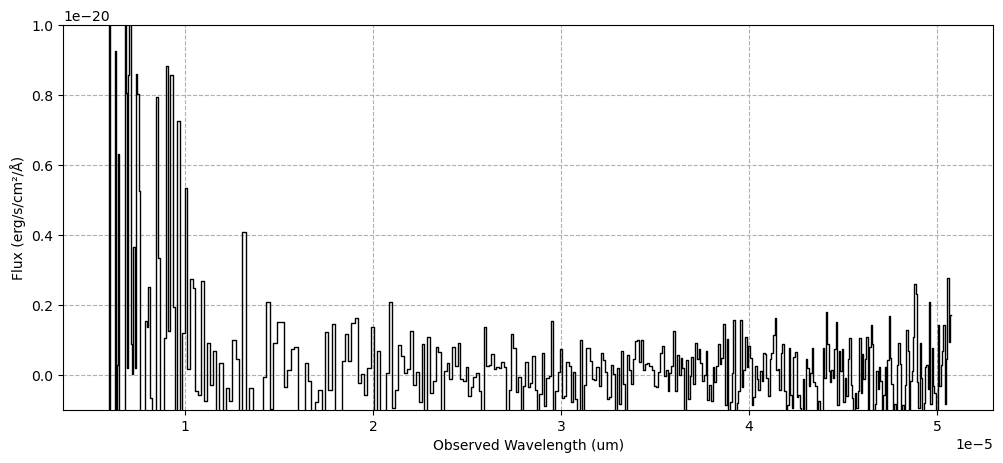

In [78]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import numpy as np

# Given redshift
redshift = 9.4383

# Convert observed wavelength to rest-frame wavelength
rest_wave = tab['wave'] / (1 + redshift)

# convert rest wavelength to um
rest_wave_um = rest_wave / 1e4

plt.figure(figsize=(12, 5))

# Plotting the data using the rest-frame wavelength
plt.plot(rest_wave_um, tab['flux_erg_per_s_cm2_A'], color='black', lw=1, drawstyle='steps-mid')

# Apply symmetrical log scale to the x-axis
#plt.xscale('symlog')

# Labeling
plt.xlabel('Observed Wavelength (um)')  
plt.ylabel('Flux (erg/s/cm²/Å)')

# Set ticks manually to ensure 1 to 5 is still visible
#plt.xticks([1, 2, 3, 4, 5])  # Change ticks for Ångströms

# Use ScalarFormatter to format the x-axis ticks as regular numbers
ax = plt.gca()  # Get current axis
ax.xaxis.set_major_formatter(ScalarFormatter())

# Grid to aid visualization
plt.grid(True, which="both", ls="--")

#plt.xlim(800, 5500)  # Set the x-axis limits in Ångströms
plt.ylim(-0.1e-20, 1.0e-20)  # Set the y-axis limits

# Show the plot
plt.show()

# the plot 


In [4]:


# Define the file path
file_path_2 = '/Users/s2537809/MUSE/primer_f356w_det_cat_photoz_v0.1_3temps_beta2 1.fits'


# Load the catalog
cat2 = Table.read(file_path_2, format='fits')

# Display the  catalog
cat2[cat2['z_spec'] > 0.0]


ID,z_spec,z_peak,z1_median,z1_min,z1_max,z1_area,z2_median,z2_min,z2_max,z2_area,z1_good_peak,pz_5p5_6p5
int64,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,bool,float32
14076,0.7057,0.6900,0.6988,0.6600,0.7450,0.885,-99.0000,-99.0000,-99.0000,-99.000,True,0.0
14472,1.2067,1.2250,1.2311,1.1500,1.3150,0.888,-99.0000,-99.0000,-99.0000,-99.000,True,0.0
14613,2.1523,1.3000,1.2559,1.1350,1.3600,0.739,2.0533,2.0100,2.1150,0.151,True,0.0
14771,0.8488,0.9200,0.9157,0.8400,0.9850,0.881,-99.0000,-99.0000,-99.0000,-99.000,True,0.0
14978,1.1804,1.2350,1.2325,1.1600,1.3050,0.877,-99.0000,-99.0000,-99.0000,-99.000,True,0.0
15024,2.1362,2.1300,2.1204,2.0250,2.2100,0.890,-99.0000,-99.0000,-99.0000,-99.000,True,0.0
15141,1.2445,1.4500,1.4472,1.3550,1.5500,0.732,1.5767,1.5550,1.6050,0.086,True,2.682312e-39
15518,1.7237,1.1250,1.1067,1.0850,1.1250,0.670,-99.0000,-99.0000,-99.0000,-99.000,True,0.0
15555,2.2236,2.1100,2.1067,2.0000,2.2050,0.900,-99.0000,-99.0000,-99.0000,-99.000,True,0.0


In [5]:
# Perform the crossmatch
primer_f356w_cat = crossmatch_catalogs_ID(cat1, cat2)

# rename ra and dec columns
primer_f356w_cat.rename_column('ALPHA_J2000', 'ra')
primer_f356w_cat.rename_column('DELTA_J2000', 'dec')

# savethe crossmatched catalog
primer_f356w_cat.write('/Users/s2537809/MUSE/primer_f356w_cat.fits', format='fits', overwrite=True)

In [6]:
primer_f356w_cat[primer_f356w_cat['z_spec']>0]

<Table length=2280>
  ID      X_IMAGE          Y_IMAGE      ... z1_good_peak   pz_5p5_6p5 
int64     float64          float64      ...     bool        float32   
----- ---------------- ---------------- ... ------------ -------------
14076 10073.5810546875    11802.8984375 ...         True           0.0
14472  9960.9169921875 11826.1103515625 ...         True           0.0
14613  10772.337890625    12114.0703125 ...         True           0.0
14771   11895.62109375  11816.951171875 ...         True           0.0
14978  12060.041015625  12149.708984375 ...         True           0.0
15024  11037.873046875  12194.951171875 ...         True           0.0
15141 10755.9365234375 12067.3662109375 ...         True  2.682312e-39
15518  12755.228515625  12542.068359375 ...         True           0.0
15555 13947.9970703125 12543.0537109375 ...         True           0.0
15564 12649.9521484375  12507.529296875 ...         True           0.0
  ...              ...              ... ...          ...           ...
71135 14486.7294921875  31422.181640625 ...         True           0.0
71210 15155.1083984375  31357.833984375 ...         True           0.0
71218   15157.67578125  31341.966796875 ...         True 2.8085717e-23
71300   16894.30078125  31296.630859375 ...         True           0.0
71393   9386.146484375      31208.71875 ...         True           0.0
71427  14019.498046875    31226.8359375 ...         True           0.0
71480  16489.412109375  31226.767578125 ...         True           0.0
71481    17104.6171875   31218.80078125 ...         True           0.0
71542  9447.5615234375   31263.22265625 ...         True           0.0
71598         12954.25     31168.046875 ...         True           0.0

# UDF-10


In [63]:


# Define the file path
file_path_1 = '/Users/s2537809/MUSE/mosaic_jades_match'


# Load the catalog
cat3 = Table.read(file_path_1, format='fits')

mosaic = cat3[cat3['DATASET'] == 'MOSAIC']

In [69]:



filepath = '/Users/s2537809/Downloads/UDF_HUDF_Catalogs_Astropy_FULL/dr2_main_09_astropy.fits'
cat4 = Table.read(filepath, format='fits')

cat4
# limit mosaic to only dataset = mosaic or mxdf
mosaic = cat4 
#mosaic = cat4[(cat4['DATASET'] == 'MOSAIC') | (cat4['DATASET'] == 'MXDF')]


# Define the file path for the new FITS file
output_filepath = '/Users/s2537809/Downloads/mosaic_subset.fits'

# Save the mosaic table as a new FITS file
mosaic.write(output_filepath, format='fits', overwrite=True)

In [70]:
cat4

ID,DATASET,DEPTH,FROM,ZCONF,MCONF,IFLAG,ZSYS,ZSYS_ERR,REFZ,Z,Z_ERR,DLYAFIT,DV_ABS,DV_ERR_ABS,DV_BALMER,DV_ERR_BALMER,DV_CIV1548,DV_ERR_CIV1548,DV_FORBIDDEN,DV_ERR_FORBIDDEN,DV_LYALPHA,DV_ERR_LYALPHA,DV_MGII2796,DV_ERR_MGII2796,RA,DEC,CENTER,IN_HST,IN_ORI,IN_DR1,IN_MXDF,IN_UDF10,RAF_ID,RAF_MIDS,CANDELS_ID,CANDELS_MIDS,3DHST_ID,3DHST_MIDS,ASTRO_ID,ASTRO_MIDS,MAG_SRC,MAG_AFLAG,MAG_F606W,MAGERR_F606W,MAG_F775W,MAGERR_F775W,MAG_F850LP,MAGERR_F850LP,MASS_PRO,LERR_MASS_PRO,HERR_MASS_PRO,MASS_MAG,LERR_MASS_MAG,HERR_MASS_MAG,SFR_PRO,LERR_SFR_PRO,HERR_SFR_PRO,SFR_MAG,LERR_SFR_MAG,HERR_SFR_MAG,LINE_SNR_MAX,SNR_MAX,FLUX_MAX,LYALPHA_EMI_FLUX,LYALPHA_EMI_SNR,LYALPHA_EMI_EQW,LYALPHA_EMI_VD,CIV1548_EMI_FLUX,CIV1548_EMI_SNR,CIV1548_EMI_EQW,CIV1548_EMI_VD,CIV1550_EMI_FLUX,CIV1550_EMI_SNR,CIV1550_EMI_EQW,CIV1550_EMI_VD,HeII1640_EMI_FLUX,HeII1640_EMI_SNR,HeII1640_EMI_EQW,HeII1640_EMI_VD,OIII1666_EMI_FLUX,OIII1666_EMI_SNR,OIII1666_EMI_EQW,OIII1666_EMI_VD,SiIII1883_EMI_FLUX,SiIII1883_EMI_SNR,SiIII1883_EMI_EQW,SiIII1883_EMI_VD,CIII1907_EMI_FLUX,CIII1907_EMI_SNR,CIII1907_EMI_EQW,CIII1907_EMI_VD,CIII1909_EMI_FLUX,CIII1909_EMI_SNR,CIII1909_EMI_EQW,CIII1909_EMI_VD,MgII2796_EMI_FLUX,MgII2796_EMI_SNR,MgII2796_EMI_EQW,MgII2796_EMI_VD,MgII2803_EMI_FLUX,MgII2803_EMI_SNR,MgII2803_EMI_EQW,MgII2803_EMI_VD,OII3726_EMI_FLUX,OII3726_EMI_SNR,OII3726_EMI_EQW,OII3726_EMI_VD,OII3729_EMI_FLUX,OII3729_EMI_SNR,OII3729_EMI_EQW,OII3729_EMI_VD,H11_EMI_FLUX,H11_EMI_SNR,H11_EMI_EQW,H11_EMI_VD,H10_EMI_FLUX,H10_EMI_SNR,H10_EMI_EQW,H10_EMI_VD,H9_EMI_FLUX,H9_EMI_SNR,H9_EMI_EQW,H9_EMI_VD,NeIII3869_EMI_FLUX,NeIII3869_EMI_SNR,NeIII3869_EMI_EQW,NeIII3869_EMI_VD,HeI3889_EMI_FLUX,HeI3889_EMI_SNR,HeI3889_EMI_EQW,HeI3889_EMI_VD,H8_EMI_FLUX,H8_EMI_SNR,H8_EMI_EQW,H8_EMI_VD,NeIII3967_EMI_FLUX,NeIII3967_EMI_SNR,NeIII3967_EMI_EQW,NeIII3967_EMI_VD,HEPSILON_EMI_FLUX,HEPSILON_EMI_SNR,HEPSILON_EMI_EQW,HEPSILON_EMI_VD,HDELTA_EMI_FLUX,HDELTA_EMI_SNR,HDELTA_EMI_EQW,HDELTA_EMI_VD,HGAMMA_EMI_FLUX,HGAMMA_EMI_SNR,HGAMMA_EMI_EQW,HGAMMA_EMI_VD,HBETA_EMI_FLUX,HBETA_EMI_SNR,HBETA_EMI_EQW,HBETA_EMI_VD,OIII4959_EMI_FLUX,OIII4959_EMI_SNR,OIII4959_EMI_EQW,OIII4959_EMI_VD,OIII5007_EMI_FLUX,OIII5007_EMI_SNR,OIII5007_EMI_EQW,OIII5007_EMI_VD,HALPHA_EMI_FLUX,HALPHA_EMI_SNR,HALPHA_EMI_EQW,HALPHA_EMI_VD,NII6584_EMI_FLUX,NII6584_EMI_SNR,NII6584_EMI_EQW,NII6584_EMI_VD,SII6717_EMI_FLUX,SII6717_EMI_SNR,SII6717_EMI_EQW,SII6717_EMI_VD,SiII1260_ABS_FLUX,SiII1260_ABS_SNR,SiII1260_ABS_EQW,SiII1260_ABS_VD,OI1302_ABS_FLUX,OI1302_ABS_SNR,OI1302_ABS_EQW,OI1302_ABS_VD,CII1334_ABS_FLUX,CII1334_ABS_SNR,CII1334_ABS_EQW,CII1334_ABS_VD,SiIV1394_ABS_FLUX,SiIV1394_ABS_SNR,SiIV1394_ABS_EQW,SiIV1394_ABS_VD,SiIV1403_ABS_FLUX,SiIV1403_ABS_SNR,SiIV1403_ABS_EQW,SiIV1403_ABS_VD,SiII1527_ABS_FLUX,SiII1527_ABS_SNR,SiII1527_ABS_EQW,SiII1527_ABS_VD,CIV1548_ABS_FLUX,CIV1548_ABS_SNR,CIV1548_ABS_EQW,CIV1548_ABS_VD,CIV1550_ABS_FLUX,CIV1550_ABS_SNR,CIV1550_ABS_EQW,CIV1550_ABS_VD,FeII1608_ABS_FLUX,FeII1608_ABS_SNR,FeII1608_ABS_EQW,FeII1608_ABS_VD,AlII1671_ABS_FLUX,AlII1671_ABS_SNR,AlII1671_ABS_EQW,AlII1671_ABS_VD,AlIII1854_ABS_FLUX,AlIII1854_ABS_SNR,AlIII1854_ABS_EQW,AlIII1854_ABS_VD,AlIII1862_ABS_FLUX,AlIII1862_ABS_SNR,AlIII1862_ABS_EQW,AlIII1862_ABS_VD,FeII2344_ABS_FLUX,FeII2344_ABS_SNR,FeII2344_ABS_EQW,FeII2344_ABS_VD,FeII2374_ABS_FLUX,FeII2374_ABS_SNR,FeII2374_ABS_EQW,FeII2374_ABS_VD,FeII2382_ABS_FLUX,FeII2382_ABS_SNR,FeII2382_ABS_EQW,FeII2382_ABS_VD,FeII2586_ABS_FLUX,FeII2586_ABS_SNR,FeII2586_ABS_EQW,FeII2586_ABS_VD,FeII2600_ABS_FLUX,FeII2600_ABS_SNR,FeII2600_ABS_EQW,FeII2600_ABS_VD,MgII2796_ABS_FLUX,MgII2796_ABS_SNR,MgII2796_ABS_EQW,MgII2796_ABS_VD,MgII2803_ABS_FLUX,MgII2803_ABS_SNR,MgII2803_ABS_EQW,MgII2803_ABS_VD,MgI2853_ABS_FLUX,MgI2853_ABS_SNR,MgI2853_ABS_EQW,MgI2853_ABS_VD,H11_ABS_FLUX,H11_ABS_SNR,H11_ABS_EQW,H11_ABS_VD,H10_ABS_FLUX,H10_ABS_SNR,H10_ABS_EQW,H10_ABS_VD,H9_ABS_FLUX,H9_ABS_SNR,H9_ABS_EQW,H9_ABS_VD,H8_ABS_FLUX,H8_ABS_SNR,H8_ABS_EQW,H8_ABS_VD,CaK_ABS_FLUX,CaK_ABS_SNR,CaK_ABS_EQW,CaK_ABS_VD,CaH_ABS_FLUX,CaH_ABS_SNR,CaH_ABS_EQW,CaH_ABS

In [60]:

mosaic = cat3[cat3['DATASET'] == 'MOSAIC']

print (len(mosaic))
mosaic

53.174896	-27.8059944

218


25.368901599999997

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpdaf.obj import Cube

# Load the cube
cube = Cube('/Users/s2537809/MUSE/DATACUBE_UDF-MOSAIC.fits')

# Sum the flux across the entire wavelength range (white light image)
white_light_image = np.sum(cube.data, axis=0)

# Create a plot
plt.figure(figsize=(10, 10))
plt.imshow(white_light_image, cmap='gray', origin='lower', aspect='auto')
plt.colorbar(label='Flux (arbitrary units)')
plt.title('White Light Image of MUSE Data Cube')
plt.xlabel('X (pixels)')
plt.ylabel('Y (pixels)')
plt.show()


KeyboardInterrupt: 

Filename: /Users/s2537809/Downloads/FIELDMAP_UDF-MOSAIC.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       7   ()      
  1  DATA          1 ImageHDU        31   (945, 947)   int64 (rescales to uint64)   
HDU list: None


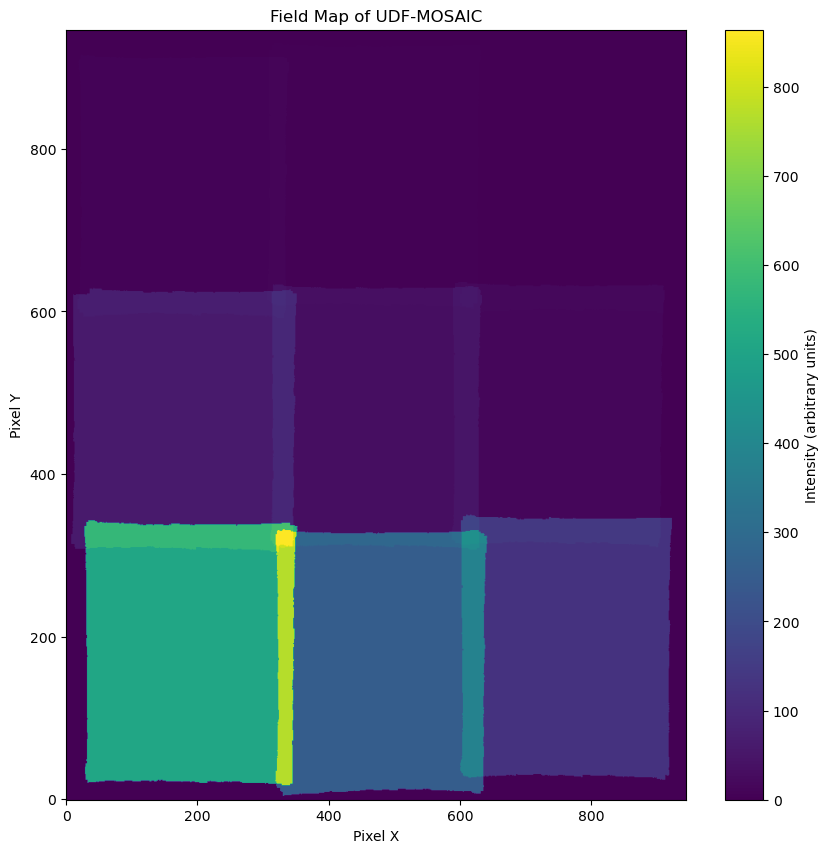

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

# Load the FITS file
file_path = '/Users/s2537809/Downloads/FIELDMAP_UDF-MOSAIC.fits'

# Open the FITS file and check the structure
with fits.open(file_path) as hdul:
    print(f"HDU list: {hdul.info()}")  # This will list the available HDUs and their names

    # Access the data from the primary HDU or the correct extension
    field_map_data = hdul[1].data  # Change the index if the data is in a different HDU (e.g., [1] for the first extension)

# Check if the data was successfully loaded
if field_map_data is None:
    print("No data found in the FITS file.")
else:
    # Check the dtype and convert to a numerical type (if necessary)
    if field_map_data.dtype == 'O':  # dtype 'O' indicates 'object', so conversion is needed
        field_map_data = np.array(field_map_data, dtype=np.float32)

    # Create a plot
    plt.figure(figsize=(10, 10))

    # Display the field map data using imshow (adjust color map and limits as needed)
    plt.imshow(field_map_data, cmap='viridis', origin='lower', aspect='auto')
    plt.colorbar(label='Intensity (arbitrary units)')  # Adjust label if necessary
    plt.title('Field Map of UDF-MOSAIC')
    plt.xlabel('Pixel X')
    plt.ylabel('Pixel Y')

    # Show the plot
    plt.show()



Filename: /Users/s2537809/Downloads/IMAGE_UDF-MOSAIC.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     301   ()      
  1  DATA          1 ImageHDU        38   (945, 947)   float32   
  2  STAT          1 ImageHDU        42   (945, 947)   float32   
HDU list: None


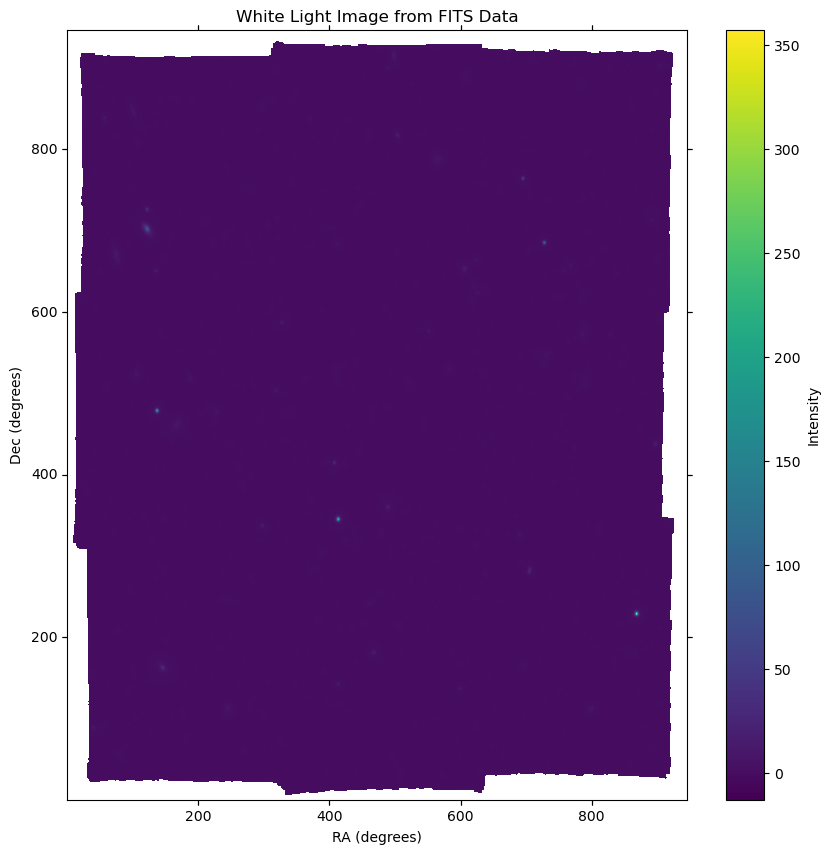

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS

# Load the FITS file
file_path = '/Users/s2537809/Downloads/IMAGE_UDF-MOSAIC.fits'

# Open the FITS file and extract data
with fits.open(file_path) as hdul:
    # Display the HDU list to see where the data is stored
    print(f"HDU list: {hdul.info()}")

    # Assuming the image data is in the primary HDU
    image_data = hdul[0].data  # Primary HDU
    if image_data is None:
        image_data = hdul[1].data  # If not found, check the first extension

# Check if data is successfully loaded
if image_data is None:
    print("No data found in the FITS file.")
else:
    # Create the WCS object from the header
    header = hdul[0].header
    wcs = WCS(header)

    # Create a plot with RA and Dec axes
    plt.figure(figsize=(10, 10))

    # Display the image data using imshow with WCS projection
    ax = plt.subplot(projection=wcs)
    ax.imshow(image_data, cmap='viridis', origin='lower', aspect='auto')

    # Add WCS-based axis labels (RA and Dec)
    ax.set_xlabel('RA (degrees)')
    ax.set_ylabel('Dec (degrees)')

    # Add a color bar
    plt.colorbar(ax.images[0], ax=ax, label='Intensity')

    # Set title and show the plot
    ax.set_title('White Light Image from FITS Data')
    plt.show()


In [13]:
from mpdaf.obj import Cube

def get_cube_ra_dec_bounds(cube):
    # Get spatial dimensions
    ny, nx = cube.shape[1], cube.shape[2]  # For example, 947 x 945
    wcs = cube.wcs

    # Define the four corners in pixel coordinates
    corners = [(0, 0), (nx-1, 0), (0, ny-1), (nx-1, ny-1)]

    # Convert each corner to RA and Dec
    ra_dec_corners = wcs.pix2sky(corners, unit='deg')
    
    # Separate RA and Dec values
    ras = [coord[1] for coord in ra_dec_corners]
    decs = [coord[0] for coord in ra_dec_corners]
    ra_min, ra_max = min(ras), max(ras)
    dec_min, dec_max = min(decs), max(decs)

    return ra_min, ra_max, dec_min, dec_max, ra_dec_corners

# Usage with your data cube
cube = Cube('/Users/s2537809/MUSE/DATACUBE_UDF-MOSAIC.fits')
ra_min, ra_max, dec_min, dec_max, ra_dec_corners= get_cube_ra_dec_bounds(cube)
print(f"RA range: {ra_min} to {ra_max} degrees")
print(f"Dec range: {dec_min} to {dec_max} degrees")
print("RA and Dec corners:", ra_dec_corners)


RA range: 53.118964157203955 to 53.20277788893667 degrees
Dec range: -27.824491111100002 to -27.750350732057203 degrees
RA and Dec corners: [[-27.82449111  53.16311222]
 [-27.78551164  53.20277789]
 [-27.78931757  53.11896416]
 [-27.75035073  53.15863282]]


In [22]:
cube.info()

[INFO] 3681 x 947 x 945 Cube (/Users/s2537809/MUSE/DATACUBE_UDF-MOSAIC.fits)
[INFO] .data(3681 x 947 x 945) (1e-20 erg / (Angstrom s cm2)), .var(3681 x 947 x 945)
[INFO] center:(-27:47:14.70052886,03:32:38.63050641) size:(189.400",189.000") step:(0.200",0.200") rot:-42.0 deg frame:FK5
[INFO] wavelength: min:4750.00 max:9350.00 step:1.25 Angstrom


/var/folders/wq/x4d7t0dd705bwvpnmkf6s7s40000gn/T/ipykernel_46241/1445701201.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ra_ticks_hms)


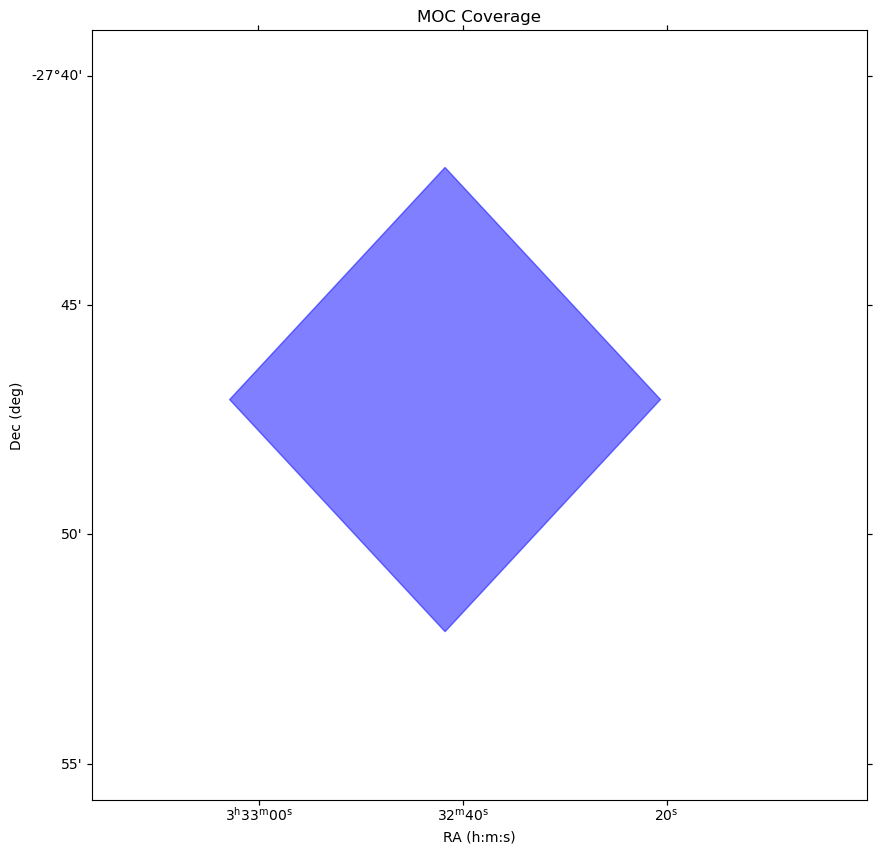

In [30]:
import astropy.units as u
import matplotlib.pyplot as plt
from mocpy import MOC
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.coordinates import Angle

# Define the actual coordinates for the four vertices of the polygon (in degrees)
ra1, dec1 = 53.16311222, -27.82449111  # Vertex 1
ra2, dec2 = 53.20277789, -27.78551164  # Vertex 2
ra3, dec3 = 53.11896416, -27.78931757  # Vertex 3
ra4, dec4 = 53.15863282, -27.75035073  # Vertex 4

# Define the vertices (RA and Dec)
vertices_ra = [ra1, ra2, ra3, ra4]
vertices_dec = [dec1, dec2, dec3, dec4]

# Create a SkyCoord object for the vertices
skycoord = SkyCoord(ra=vertices_ra, dec=vertices_dec, unit=u.deg)

# Create MOC from polygon
moc = MOC.from_polygon_skycoord(skycoord, max_depth=10)

# Create a Matplotlib figure
fig = plt.figure(figsize=(10, 10))

# Set up WCS for RA and Dec using compatible projections
wcs = WCS(naxis=2)
wcs.wcs.ctype = ["RA---SIN", "DEC--SIN"]  # RA and DEC both use SIN projection
wcs.wcs.crval = [53.16, -27.79]  # Center of the field
wcs.wcs.crpix = [fig.get_figwidth() * 50, fig.get_figheight() * 50]
wcs.wcs.cdelt = [-0.00028, 0.00028]  # Pixel scale

# Add a subplot with the WCS projection
ax = fig.add_subplot(111, projection=wcs)

# Plot the MOC on the axis
moc.fill(ax=ax, wcs=wcs, color='blue', alpha=0.5)  # Customize color and alpha as needed

# Set axis labels for RA (h:m:s) and Dec (deg)
ax.set_xlabel('RA (h:m:s)')
ax.set_ylabel('Dec (deg)')

# Convert RA ticks from degrees to h:m:s format
ra_ticks = ax.get_xticks()
ra_ticks_hms = [Angle(ra, unit=u.deg).to_string(unit=u.hour, sep=':') for ra in ra_ticks]
ax.set_xticklabels(ra_ticks_hms)

# Add title and show the plot
ax.set_title('MOC Coverage')
plt.show()


In [42]:

# Step 1: Read the CSV file
csv_file = '/Users/s2537809/Downloads/mosaic_DJA.csv'  # Path to your CSV file
csv_data = Table.read(csv_file, format='csv')

csv_data

jname,ndup,uid,ra,dec,file,root,srcid,nGr,Grating,grade,zfit,z,comment,References,nRef,sn50,wmin,wmax,Lya,Ha,OIII,L_Ha,L_OIII,HST,NIRCam,slit,FITS,Fnu,Flam
str20,int64,int64,float64,float64,str53,str18,int64,int64,str29,int64,float64,float64,str138,str64,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,str17,int64,int64
j033234.34m274914.78,5,7267,53.143084,-27.820772,gds-deep-v3_g140m-f070lp_1210_10642.spec.fits,gds-deep-v3,10642,0,--,3,1.9033,1.9033,Redshifts match v2 grade=3,ABu23 z=1.902,1,1.23,0.74,1.26,--,--,--,--,--,--,--,--,FITS zfit spl,--,--
j033228.97m274903.77,5,7272,53.120726,-27.817714,gds-deep-v3_g140m-f070lp_1210_10770.spec.fits,gds-deep-v3,10770,0,--,3,1.2953,1.2953,Redshift matches gds-deep-v3_prism-clear_1210_10770 z=1.2988,ABu23 z=1.295,1,0.83,0.77,1.26,--,--,--,--,40.67,--,--,--,FITS zfit spl,--,--
j033230.00m274612.78,9,7288,53.12499,-27.770218,gds-deep-v3_g140m-f070lp_1210_12170.spec.fits,gds-deep-v3,12170,0,--,3,1.2887,1.2887,Redshifts match v2 grade=3,ABu23 z=N/A,1,0.45,0.7,1.26,--,--,--,--,39.86,--,--,--,FITS zfit spl,--,--
j033228.75m274604.47,5,7289,53.119773,-27.767909,gds-deep-v3_g140m-f070lp_1210_12284.spec.fits,gds-deep-v3,12284,0,--,3,1.3061,1.3061,Redshifts match v2 grade=3,ABu23 z=1.306,1,0.99,0.7,1.26,--,--,--,--,40.65,--,--,--,FITS zfit spl,--,--
j033229.42m274549.44,5,7291,53.122577,-27.763733,gds-deep-v3_g140m-f070lp_1210_12477.spec.fits,gds-deep-v3,12477,0,--,3,0.6699,0.6699,Redshifts match v2 grade=3,ABu23 z=0.670,1,1.9,0.7,1.26,--,4.9,--,39.89,40.39,--,--,--,FITS zfit spl,--,--
j033229.22m274751.48,5,7301,53.121759,-27.797633,gds-deep-v3_g140m-f070lp_1210_13176.spec.fits,gds-deep-v3,13176,0,--,3,5.9352,5.9352,Redshifts match v2 grade=3,JWi23 z=5.937 ; ABu23 z=5.936 ; CSi23 z=N/A,3,2.31,0.7,1.26,24.3,--,--,--,--,--,--,--,FITS zfit spl,--,--
j033232.38m274621.74,5,7302,53.134923,-27.772706,gds-deep-v3_g140m-f070lp_1210_13197.spec.fits,gds-deep-v3,13197,0,--,3,6.3353,6.3353,Redshifts match v2 grade=3,CSi23 z=N/A ; JWi23 z=6.336 ; ABu23 z=6.335,3,2.08,0.7,1.26,22.9,--,--,--,--,--,--,--,FITS zfit spl,--,--
j033230.72m274540.88,5,7307,53.127985,-27.761357,gds-deep-v3_g140m-f070lp_1210_13393.spec.fits,gds-deep-v3,13393,0,--,1,0.3991,0.3991,--,ABu23 z=N/A,1,1.87,0.7,1.26,--,14.7,--,39.89,40.11,--,--,--,FITS zfit spl,--,--
j033229.79m274756.91,5,7309,53.124127,-27.799142,gds-deep-v3_g140m-f070lp_1210_13545.spec.fits,gds-deep-v3,13545,0,--,3,4.0422,4.0422,Redshift matches gds-deep-v3_prism-clear_1210_13545 z=4.0382,CSi23 z=N/A ; ABu23 z=4.035,2,0.67,0.7,1.26,--,--,--,--,--,--,--,--,FITS zfit spl,--,--


In [40]:
import astropy.units as u
from astropy.table import Table
from mocpy import MOC
from astropy.coordinates import SkyCoord

# Step 1: Read the CSV file
csv_file = '/Users/s2537809/Downloads/mosaic_DJA.csv'  # Path to your CSV file
csv_data = Table.read(csv_file, format='csv')

# Step 2: Define the MOC from the polygon (same polygon used earlier)
ra1, dec1 = 53.16311222, -27.82449111  # Vertex 1
ra2, dec2 = 53.20277789, -27.78551164  # Vertex 2
ra3, dec3 = 53.11896416, -27.78931757  # Vertex 3
ra4, dec4 = 53.15863282, -27.75035073  # Vertex 4

# Define the vertices (RA and Dec)
vertices_ra = [ra1, ra2, ra3, ra4]
vertices_dec = [dec1, dec2, dec3, dec4]

# Create a SkyCoord object for the vertices
skycoord = SkyCoord(ra=vertices_ra, dec=vertices_dec, unit=u.deg)

# Create MOC from polygon
moc = MOC.from_polygon_skycoord(skycoord, max_depth=10)

# Step 3: Extract RA and Dec of sources from CSV
ra_sources = csv_data['ra']
dec_sources = csv_data['dec']

# Step 4: Check if sources are inside the MOC
sky_coords = SkyCoord(ra=ra_sources, dec=dec_sources, unit=u.deg)

# Create a mask for sources inside the MOC
inside_moc_mask = moc.contains(sky_coords.ra, sky_coords.dec)

# Step 5: Filter the sources that are inside the MOC
filtered_sources = csv_data[inside_moc_mask]

# Step 6: Display the filtered sources (or save to a new CSV)
filtered_sources



/var/folders/wq/x4d7t0dd705bwvpnmkf6s7s40000gn/T/ipykernel_46241/2678295702.py:34: DeprecationWarning: This method is deprecated and has been replaced by contains_lonlat
  inside_moc_mask = moc.contains(sky_coords.ra, sky_coords.dec)


jname,ndup,uid,ra,dec,file,root,srcid,nGr,Grating,grade,zfit,z,comment,References,nRef,sn50,wmin,wmax,Lya,Ha,OIII,L_Ha,L_OIII,HST,NIRCam,slit,FITS,Fnu,Flam
str20,int64,int64,float64,float64,str53,str18,int64,int64,str29,int64,float64,float64,str138,str64,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,str17,int64,int64
j033234.34m274914.78,5,7267,53.143084,-27.820772,gds-deep-v3_g140m-f070lp_1210_10642.spec.fits,gds-deep-v3,10642,0,--,3,1.9033,1.9033,Redshifts match v2 grade=3,ABu23 z=1.902,1,1.23,0.74,1.26,--,--,--,--,--,--,--,--,FITS zfit spl,--,--
j033228.97m274903.77,5,7272,53.120726,-27.817714,gds-deep-v3_g140m-f070lp_1210_10770.spec.fits,gds-deep-v3,10770,0,--,3,1.2953,1.2953,Redshift matches gds-deep-v3_prism-clear_1210_10770 z=1.2988,ABu23 z=1.295,1,0.83,0.77,1.26,--,--,--,--,40.67,--,--,--,FITS zfit spl,--,--
j033230.00m274612.78,9,7288,53.12499,-27.770218,gds-deep-v3_g140m-f070lp_1210_12170.spec.fits,gds-deep-v3,12170,0,--,3,1.2887,1.2887,Redshifts match v2 grade=3,ABu23 z=N/A,1,0.45,0.7,1.26,--,--,--,--,39.86,--,--,--,FITS zfit spl,--,--
j033228.75m274604.47,5,7289,53.119773,-27.767909,gds-deep-v3_g140m-f070lp_1210_12284.spec.fits,gds-deep-v3,12284,0,--,3,1.3061,1.3061,Redshifts match v2 grade=3,ABu23 z=1.306,1,0.99,0.7,1.26,--,--,--,--,40.65,--,--,--,FITS zfit spl,--,--
j033229.42m274549.44,5,7291,53.122577,-27.763733,gds-deep-v3_g140m-f070lp_1210_12477.spec.fits,gds-deep-v3,12477,0,--,3,0.6699,0.6699,Redshifts match v2 grade=3,ABu23 z=0.670,1,1.9,0.7,1.26,--,4.9,--,39.89,40.39,--,--,--,FITS zfit spl,--,--
j033229.22m274751.48,5,7301,53.121759,-27.797633,gds-deep-v3_g140m-f070lp_1210_13176.spec.fits,gds-deep-v3,13176,0,--,3,5.9352,5.9352,Redshifts match v2 grade=3,JWi23 z=5.937 ; ABu23 z=5.936 ; CSi23 z=N/A,3,2.31,0.7,1.26,24.3,--,--,--,--,--,--,--,FITS zfit spl,--,--
j033232.38m274621.74,5,7302,53.134923,-27.772706,gds-deep-v3_g140m-f070lp_1210_13197.spec.fits,gds-deep-v3,13197,0,--,3,6.3353,6.3353,Redshifts match v2 grade=3,CSi23 z=N/A ; JWi23 z=6.336 ; ABu23 z=6.335,3,2.08,0.7,1.26,22.9,--,--,--,--,--,--,--,FITS zfit spl,--,--
j033230.72m274540.88,5,7307,53.127985,-27.761357,gds-deep-v3_g140m-f070lp_1210_13393.spec.fits,gds-deep-v3,13393,0,--,1,0.3991,0.3991,--,ABu23 z=N/A,1,1.87,0.7,1.26,--,14.7,--,39.89,40.11,--,--,--,FITS zfit spl,--,--
j033229.79m274756.91,5,7309,53.124127,-27.799142,gds-deep-v3_g140m-f070lp_1210_13545.spec.fits,gds-deep-v3,13545,0,--,3,4.0422,4.0422,Redshift matches gds-deep-v3_prism-clear_1210_13545 z=4.0382,CSi23 z=N/A ; ABu23 z=4.035,2,0.67,0.7,1.26,--,--,--,--,--,--,--,--,FITS zfit spl,--,--


In [44]:
# limit redshift of filtered sources to z>5.5

filtered_sources = filtered_sources[filtered_sources['z'] > 5.5]

filtered_sources

jname,ndup,uid,ra,dec,file,root,srcid,nGr,Grating,grade,zfit,z,comment,References,nRef,sn50,wmin,wmax,Lya,Ha,OIII,L_Ha,L_OIII,HST,NIRCam,slit,FITS,Fnu,Flam
str20,int64,int64,float64,float64,str53,str18,int64,int64,str29,int64,float64,float64,str138,str64,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,str17,int64,int64
j033229.22m274751.48,5,7301,53.121759,-27.797633,gds-deep-v3_g140m-f070lp_1210_13176.spec.fits,gds-deep-v3,13176,0,--,3,5.9352,5.9352,Redshifts match v2 grade=3,JWi23 z=5.937 ; ABu23 z=5.936 ; CSi23 z=N/A,3,2.31,0.7,1.26,24.3,--,--,--,--,--,--,--,FITS zfit spl,--,--
j033232.38m274621.74,5,7302,53.134923,-27.772706,gds-deep-v3_g140m-f070lp_1210_13197.spec.fits,gds-deep-v3,13197,0,--,3,6.3353,6.3353,Redshifts match v2 grade=3,CSi23 z=N/A ; JWi23 z=6.336 ; ABu23 z=6.335,3,2.08,0.7,1.26,22.9,--,--,--,--,--,--,--,FITS zfit spl,--,--
j033240.19m274619.22,5,7315,53.167464,-27.772006,gds-deep-v3_g140m-f070lp_1210_13682.spec.fits,gds-deep-v3,13682,0,--,3,7.2775,7.2775,Redshifts match v2 grade=3,JWi23 z=7.276 ; ASa23 z=7.278 ; ABu23 z=7.275,3,0.25,0.7,1.26,10.4,--,--,--,--,--,--,--,FITS zfit spl,--,--
j033230.37m274905.13,5,7316,53.126535,-27.818092,gds-deep-v3_g140m-f070lp_1210_13704.spec.fits,gds-deep-v3,13704,0,--,3,5.9268,5.9268,Redshifts match v2 grade=3,DKo24 z=5.920 ; CSi23 z=N/A ; ABu23 z=5.920,3,0.96,0.75,1.26,3.0,--,--,--,--,--,--,--,FITS zfit spl,--,--
j033237.64m274601.76,9,7364,53.156837,-27.767155,gds-deep-v3_g140m-f070lp_1210_5173.spec.fits,gds-deep-v3,5173,0,--,3,7.9842,7.9842,Redshifts match v2 grade=3,JWi23 z=7.980 ; CSi23 z=N/A ; ABu23 z=7.980,3,0.35,0.7,1.26,5.0,--,--,--,--,--,--,--,FITS zfit spl,--,--
j033239.09m274609.42,5,7367,53.162878,-27.769284,gds-deep-v3_g140m-f070lp_1210_5447.spec.fits,gds-deep-v3,5447,0,--,3,6.5954,6.5954,Redshift matches gds-deep-v3_prism-clear_1210_5447 z=6.6256,ABu23 z=6.623,1,0.28,0.7,1.26,--,--,--,--,--,--,--,--,FITS zfit spl,--,--
j033238.55m274617.77,5,7634,53.160634,-27.771604,gds-deep-v3_g140m-f070lp_1210_9880.spec.fits,gds-deep-v3,9880,0,--,3,5.9776,5.9776,Redshifts match v2 grade=3,JWi23 z=5.974 ; CSi23 z=N/A ; ABu23 z=5.974,3,0.99,0.7,1.26,5.6,--,--,--,--,--,--,--,FITS zfit spl,--,--
j033240.57m274643.82,5,7636,53.169055,-27.778838,gds-deep-v3_g140m-f070lp_1210_9903.spec.fits,gds-deep-v3,9903,0,--,3,6.6362,6.6362,Redshifts match v2 grade=3,JWi23 z=6.631 ; ABu23 z=6.631 ; CSi23 z=N/A,3,0.67,0.7,1.26,8.4,--,--,--,--,--,--,--,FITS zfit spl,--,--
j033229.22m274751.48,5,7301,53.121759,-27.797633,gds-deep-v3_g235m-f170lp_1210_13176.spec.fits,gds-deep-v3,13176,0,--,3,5.9358,5.9358,interactive fit -1 15 1.3 11,JWi23 z=5.937 ; ABu23 z=5.936 ; CSi23 z=N/A,3,2.22,1.7,3.15,--,--,--,--,--,--,--,--,FITS zfit spl,--,--


In [32]:
# Check if specific coordinates are inside the MOC
test_coord = SkyCoord(ra=53.18, dec=-27.80, unit=u.deg)  # Example RA, Dec to check

# Check if the coordinate is contained within the MOC
is_inside = moc.contains(test_coord.ra, test_coord.dec)  # Pass RA and Dec separately
print(f"Coordinate {test_coord} inside MOC: {is_inside}")


Coordinate <SkyCoord (ICRS): (ra, dec) in deg
    (53.18, -27.8)> inside MOC: [ True]


/var/folders/wq/x4d7t0dd705bwvpnmkf6s7s40000gn/T/ipykernel_46241/3796302024.py:5: DeprecationWarning: This method is deprecated and has been replaced by contains_lonlat
  is_inside = moc.contains(test_coord.ra, test_coord.dec)  # Pass RA and Dec separately


In [34]:
# Read sources from the 'mosaic_subset.fits' file
sources_data = fits.open('/Users/s2537809/Downloads/mosaic_subset.fits')[1].data  # Modify path accordingly
ra_sources = sources_data['RA']
dec_sources = sources_data['DEC']

# Initialize counters for inside and outside
inside_count = 0
outside_count = 0

# Check each source if it's inside the MOC
for ra, dec in zip(ra_sources, dec_sources):
    # Create SkyCoord object for each source
    source_coord = SkyCoord(ra=ra, dec=dec, unit=u.deg)
    
    # Check if the source is inside the MOC
    is_inside = moc.contains(source_coord.ra, source_coord.dec)  # Pass RA and Dec separately
    
    # Increment counters based on whether the source is inside or outside
    if is_inside:
        inside_count += 1
    else:
        outside_count += 1

# Print the counts
print(f"Number of sources inside the MOC: {inside_count}")
print(f"Number of sources outside the MOC: {outside_count}")

/var/folders/wq/x4d7t0dd705bwvpnmkf6s7s40000gn/T/ipykernel_46241/1516727446.py:2: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/s2537809/Downloads/mosaic_subset.fits'>
  sources_data = fits.open('/Users/s2537809/Downloads/mosaic_subset.fits')[1].data  # Modify path accordingly
/var/folders/wq/x4d7t0dd705bwvpnmkf6s7s40000gn/T/ipykernel_46241/1516727446.py:16: DeprecationWarning: This method is deprecated and has been replaced by contains_lonlat
  is_inside = moc.contains(source_coord.ra, source_coord.dec)  # Pass RA and Dec separately


Number of sources inside the MOC: 1374
Number of sources outside the MOC: 0


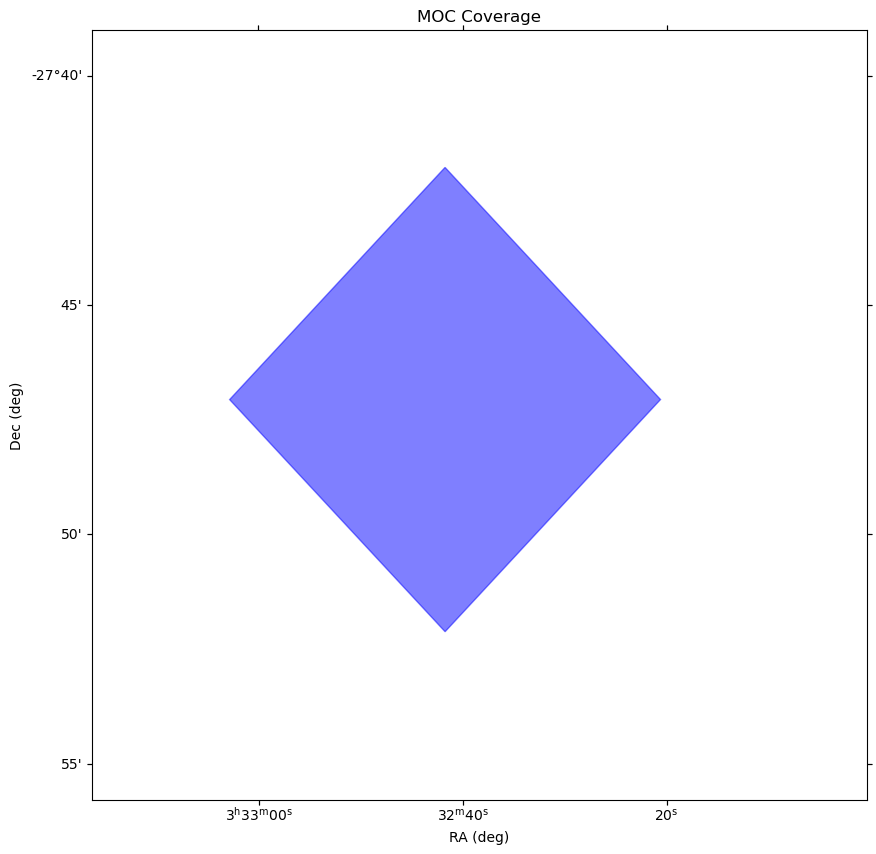

In [28]:
import astropy.units as u
import matplotlib.pyplot as plt
from mocpy import MOC
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS

# Define the actual coordinates for the four vertices of the polygon (in degrees)
ra1, dec1 = 53.16311222, -27.82449111  # Vertex 1
ra2, dec2 = 53.20277789, -27.78551164  # Vertex 2
ra3, dec3 = 53.11896416, -27.78931757  # Vertex 3
ra4, dec4 = 53.15863282, -27.75035073  # Vertex 4

# Define the vertices (RA and Dec)
vertices_ra = [ra1, ra2, ra3, ra4]
vertices_dec = [dec1, dec2, dec3, dec4]

# Create a SkyCoord object for the vertices
skycoord = SkyCoord(ra=vertices_ra, dec=vertices_dec, unit=u.deg)

# Create MOC from polygon
moc = MOC.from_polygon_skycoord(skycoord, max_depth=10)

# Create a Matplotlib figure
fig = plt.figure(figsize=(10, 10))

# Set up WCS (World Coordinate System)
wcs = WCS(naxis=2)
wcs.wcs.ctype = ["RA---TAN", "DEC--TAN"]
wcs.wcs.crval = [53.16, -27.79]  # Center of the field
wcs.wcs.crpix = [fig.get_figwidth() * 50, fig.get_figheight() * 50]
wcs.wcs.cdelt = [-0.00028, 0.00028]  # Pixel scale

# Add a subplot with the WCS projection
ax = fig.add_subplot(111, projection=wcs)

# Use the `fill` method to plot the MOC on the axis
moc.fill(ax=ax, wcs=wcs, color='blue', alpha=0.5)  # Customize color and alpha as needed

# Set axis labels for RA and Dec in degrees
ax.set_xlabel('RA (deg)')
ax.set_ylabel('Dec (deg)')

# Add title and show the plot
ax.set_title('MOC Coverage')
plt.show()
 


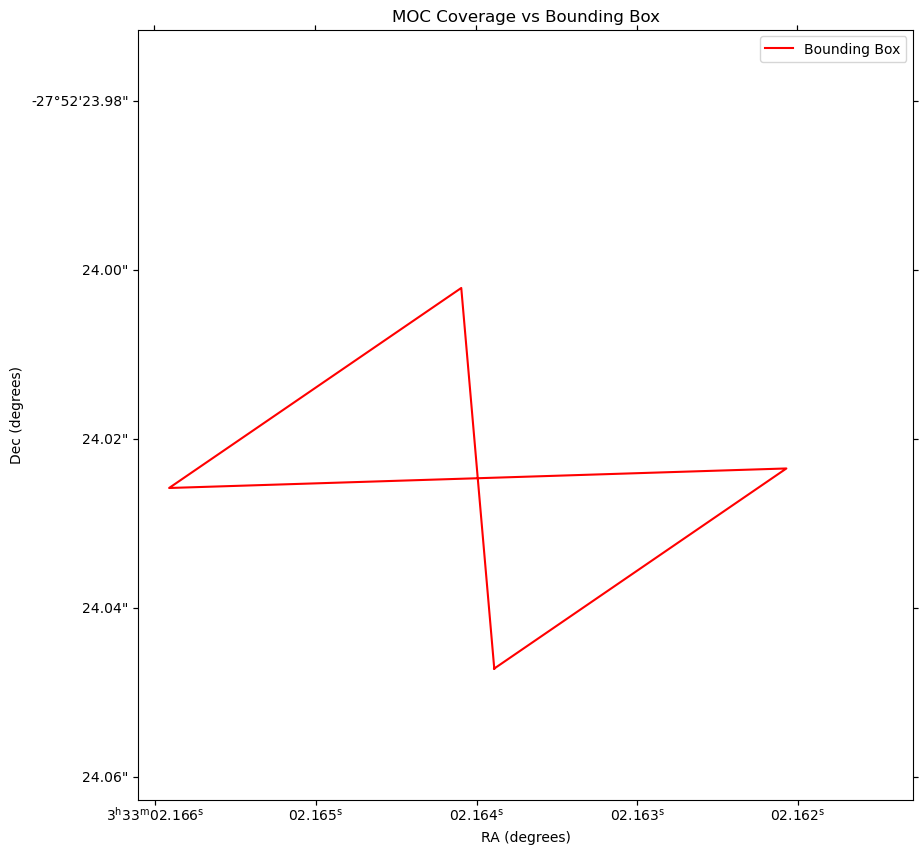

In [20]:
import astropy.units as u
import matplotlib.pyplot as plt
from mocpy import MOC
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS

# Define the actual coordinates for the four vertices of the polygon (in degrees)
ra1, dec1 = 53.16311222, -27.82449111  # Vertex 1
ra2, dec2 = 53.20277789, -27.78551164  # Vertex 2
ra3, dec3 = 53.11896416, -27.78931757  # Vertex 3
ra4, dec4 = 53.15863282, -27.75035073  # Vertex 4

# Define the vertices (RA and Dec)
vertices_ra = [ra1, ra2, ra3, ra4]
vertices_dec = [dec1, dec2, dec3, dec4]

# Create a SkyCoord object for the vertices
skycoord = SkyCoord(ra=vertices_ra, dec=vertices_dec, unit=u.deg)

# Create MOC from polygon
moc = MOC.from_polygon_skycoord(skycoord, max_depth=10)

# Create a Matplotlib figure
fig = plt.figure(figsize=(10, 10))

# Set up the WCS (World Coordinate System)
wcs = moc.wcs(fig)

# Add a subplot with the WCS projection
ax = fig.add_subplot(111, projection=wcs)

# Use the `fill` method to plot the MOC on the axis
#moc.fill(ax, wcs, color='blue', alpha=0.5)  # Customize color and alpha as needed

# Plot the bounding box (polygon) on the same axis
ax.plot(vertices_ra + [vertices_ra[0]], vertices_dec + [vertices_dec[0]], 'r-', label='Bounding Box')

# Set axis labels for RA and Dec in degrees
ax.set_xlabel('RA (degrees)')
ax.set_ylabel('Dec (degrees)')

# Add title and show the plot
ax.set_title('MOC Coverage vs Bounding Box')

# Add a legend to identify the polygon and MOC
ax.legend()

# Optionally, adjust ticks for RA and Dec (in degrees)
ax.set_xticks([53.15, 53.18, 53.2, 53.22])  # Adjust these ticks based on your RA range
ax.set_yticks([-27.85, -27.8, -27.75, -27.7])  # Adjust these ticks based on your Dec range

# Show the plot
plt.show()


/var/folders/wq/x4d7t0dd705bwvpnmkf6s7s40000gn/T/ipykernel_46241/3918430014.py:22: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/s2537809/Downloads/mosaic_subset.fits'>
  sources_data = fits.open('/Users/s2537809/Downloads/mosaic_subset.fits')[1].data  # Modify path accordingly


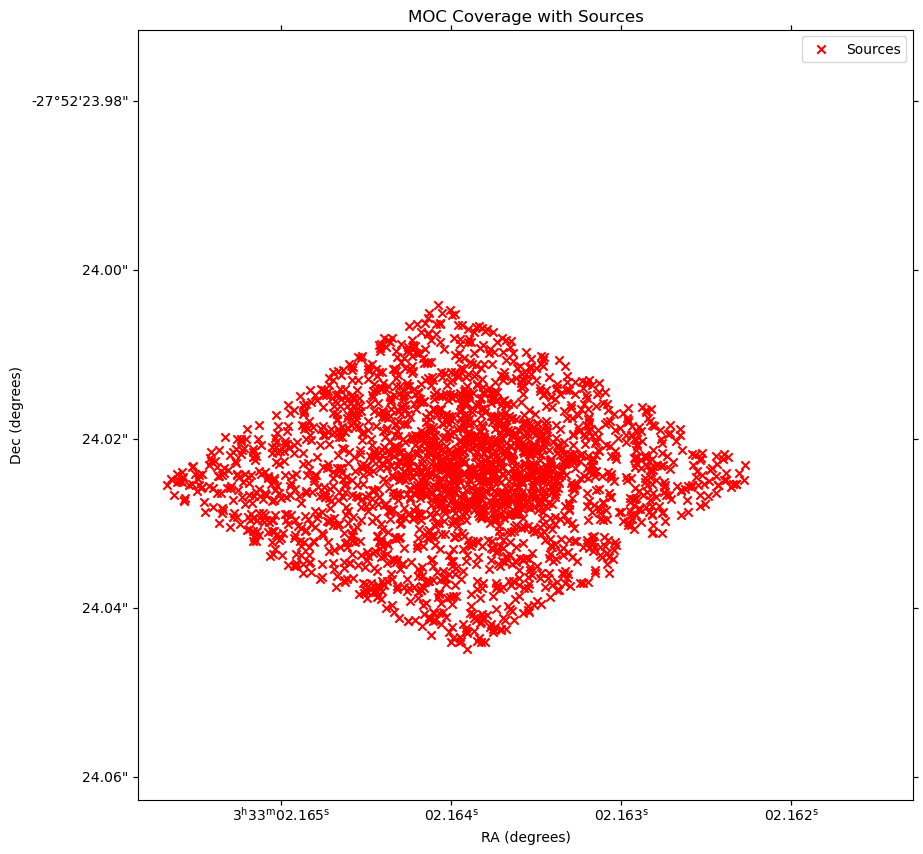

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.coordinates import SkyCoord
import astropy.units as u
from mocpy import MOC
from mpdaf.obj import Cube

# Load the MUSE cube and create MOC from the polygon (as previously defined)
cube = Cube('/Users/s2537809/MUSE/DATACUBE_UDF-MOSAIC.fits')
ra1, dec1 = 53.16311222, -27.82449111  # Vertex 1
ra2, dec2 = 53.20277789, -27.78551164  # Vertex 2
ra3, dec3 = 53.11896416, -27.78931757  # Vertex 3
ra4, dec4 = 53.15863282, -27.75035073  # Vertex 4

vertices_ra = [ra1, ra2, ra3, ra4]
vertices_dec = [dec1, dec2, dec3, dec4]
skycoord = SkyCoord(ra=vertices_ra, dec=vertices_dec, unit=u.deg)
moc = MOC.from_polygon_skycoord(skycoord, max_depth=10)

# Read sources from the 'mosaic_subset.fits' file
sources_data = fits.open('/Users/s2537809/Downloads/mosaic_subset.fits')[1].data  # Modify path accordingly
ra_sources = sources_data['RA']
dec_sources = sources_data['DEC']

# Create a Matplotlib figure
fig = plt.figure(figsize=(10, 10))
wcs = moc.wcs(fig)

# Add a subplot with the WCS projection
ax = fig.add_subplot(111, projection=wcs)

# Plot the MOC coverage
#moc.fill(ax, wcs, color='blue', alpha=0.5)

# Plot the source positions
ax.scatter(ra_sources, dec_sources, color='red', marker='x', label='Sources', zorder=5)

# Set axis labels for RA and Dec in degrees
ax.set_xlabel('RA (degrees)')
ax.set_ylabel('Dec (degrees)')
ax.set_title('MOC Coverage with Sources')

# Optional: adjust the ticks and make sure they are in degrees
ax.set_xticks([53.15, 53.18, 53.2, 53.22])  # Adjust these ticks based on your RA range
ax.set_yticks([-27.85, -27.8, -27.75, -27.7])  # Adjust these ticks based on your Dec range
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: f'{x:.5f}'))

# Add a legend and show the plot
ax.legend()
plt.show()


In [3]:
# Read sources from the 'mosaic_subset.fits' file
sources_data = fits.open('/Users/s2537809/Downloads/mosaic_subset.fits')[1].data  # Modify path accordingly
ra_sources = sources_data['RA']
dec_sources = sources_data['DEC']

# find the corners of the sorce catalog
ra_min, ra_max = min(ra_sources), max(ra_sources)

dec_min, dec_max = min(dec_sources), max(dec_sources)

print(f"RA range: {ra_min} to {ra_max} degrees")
print(f"Dec range: {dec_min} to {dec_max} degrees")

RA range: 53.12420399 to 53.19842838 degrees
Dec range: -27.82074777 to -27.75372887 degrees


/var/folders/wq/x4d7t0dd705bwvpnmkf6s7s40000gn/T/ipykernel_46241/1589412489.py:2: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/s2537809/Downloads/mosaic_subset.fits'>
  sources_data = fits.open('/Users/s2537809/Downloads/mosaic_subset.fits')[1].data  # Modify path accordingly


In [10]:
import os
import requests
from astropy.table import Table

# Read the CSV file
csv = Table.read('/Users/s2537809/Downloads/mosaic_DJA.csv', format='csv')

# Define the folder name
folder_name = 'DJA_Mosaic'

# Check if the folder exists, and create it if it doesn't
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

# Loop through each row in the CSV table
for row in csv:
    # Get root and filename from the current row
    root = row['root']
    filename = row['file']
    target_url = f"https://s3.amazonaws.com/msaexp-nirspec/extractions/{root}/{filename}"

    # Define the file path
    file_path = os.path.join(folder_name, filename)

    # Check if the file already exists
    if os.path.exists(file_path):
        print(f"{filename} already exists in {folder_name}. No need to download.")
    else:
        # File doesn't exist, download it
        try:
            response = requests.get(target_url)
            if response.status_code == 200:
                with open(file_path, 'wb') as file:
                    file.write(response.content)
                print(f"{filename} downloaded to {folder_name}.")
            else:
                print(f"Failed to download {filename}. Status code: {response.status_code}")
        except Exception as e:
            print(f"An error occurred while downloading {filename}: {str(e)}")


gds-deep-v3_g140m-f070lp_1210_10642.spec.fits downloaded to DJA_Mosaic.
gds-deep-v3_g140m-f070lp_1210_10770.spec.fits downloaded to DJA_Mosaic.
gds-deep-v3_g140m-f070lp_1210_12170.spec.fits downloaded to DJA_Mosaic.
gds-deep-v3_g140m-f070lp_1210_12284.spec.fits downloaded to DJA_Mosaic.
gds-deep-v3_g140m-f070lp_1210_12477.spec.fits downloaded to DJA_Mosaic.
gds-deep-v3_g140m-f070lp_1210_13176.spec.fits downloaded to DJA_Mosaic.
gds-deep-v3_g140m-f070lp_1210_13197.spec.fits downloaded to DJA_Mosaic.
gds-deep-v3_g140m-f070lp_1210_13393.spec.fits downloaded to DJA_Mosaic.
gds-deep-v3_g140m-f070lp_1210_13545.spec.fits downloaded to DJA_Mosaic.
gds-deep-v3_g140m-f070lp_1210_13597.spec.fits downloaded to DJA_Mosaic.
gds-deep-v3_g140m-f070lp_1210_13682.spec.fits downloaded to DJA_Mosaic.
gds-deep-v3_g140m-f070lp_1210_13704.spec.fits downloaded to DJA_Mosaic.
gds-deep-v3_g140m-f070lp_1210_1790.spec.fits downloaded to DJA_Mosaic.
gds-deep-v3_g140m-f070lp_1210_2075.spec.fits downloaded to DJA_Mo

KeyboardInterrupt: 

In [78]:
cube.get_step(unit_wave=u.angstrom, unit_wcs=u.arcsec)

array([1.25, 0.2 , 0.2 ])

In [79]:
ima = cube.sum(axis=0)
type(ima)

plt.figure()
ima.plot(scale='arcsinh', colorbar='v')

In [5]:
from astropy.wcs import WCS
import numpy as np
import matplotlib.pyplot as plt
from mpdaf.obj import Spectrum

def extract_source(cube, ra, dec, redshift, rest_wavelength_range, spatial_extent):
    """
    Extract a 2D stacked image and a 1D spectrum for a given source.

    Parameters:
    - cube: MPDAF Cube object
    - ra: Right Ascension of the source (in degrees)
    - dec: Declination of the source (in degrees)
    - redshift: Redshift of the source
    - rest_wavelength_range: Tuple of (lambda_min, lambda_max) in Angstroms (rest frame)
    - spatial_extent: Half-size of the box in pixels around the source

    Returns:
    - stacked_image: 2D stacked image (summed over wavelengths)
    - spectrum: 1D spectrum of the source
    """
    # Convert RA/Dec to pixel coordinates using cube.wcs.sky2pix
    pix_coords = cube.wcs.sky2pix([[dec, ra]], unit='deg')[0]
    print(f"Pixel coordinates: {pix_coords}")

    # Check if the coordinates are valid (not NaN)
    if np.isnan(pix_coords).any():
        raise ValueError(f"Invalid RA/Dec coordinates: RA={ra}, Dec={dec} fall outside the cube field of view.")

    x_center, y_center = int(pix_coords[0]), int(pix_coords[1])

    # Calculate the observed wavelength range
    lambda_min_obs = rest_wavelength_range[0] * (1 + redshift)
    lambda_max_obs = rest_wavelength_range[1] * (1 + redshift)

    # Convert wavelength range to pixel indices
    wave_start = np.argmin(np.abs(cube.wave.coord() - lambda_min_obs))
    wave_end = np.argmin(np.abs(cube.wave.coord() - lambda_max_obs))

    # Extract the subcube around the source in pixel coordinates
    x_slice = slice(x_center - spatial_extent, x_center + spatial_extent)
    y_slice = slice(y_center - spatial_extent, y_center + spatial_extent)

    # Ensure the slices are within cube bounds
    x_slice = slice(max(0, x_slice.start), min(cube.shape[2], x_slice.stop))
    y_slice = slice(max(0, y_slice.start), min(cube.shape[1], y_slice.stop))

    subcube = cube[wave_start:wave_end, y_slice, x_slice]

    # Sum along the wavelength axis to get a 2D stacked image
    stacked_image = subcube.data.sum(axis=0)

    # Extract the spectrum by averaging over the spatial region
    spectrum_data = subcube.data.mean(axis=(1, 2))

    # Ensure that the wavelength and flux arrays are correctly passed to the Spectrum
    spectrum_wave = subcube.wave.coord()
    if spectrum_wave is not None and spectrum_data is not None:
        spectrum = Spectrum(lamb=spectrum_wave, flux=spectrum_data)
        print("Spectrum initialized correctly.")
    else:
        raise ValueError("Invalid wavelength or flux data in subcube.")
    
    # Change spectrum wave to rest frame
    spectrum_wave = spectrum_wave / (1 + redshift)

    # Extract the pixel positions for the edges of the plot
    ny, nx = stacked_image.shape
    x_pix = np.arange(nx)
    y_pix = np.arange(ny)

    # Convert the pixel coordinates at the edges to RA/Dec using the cube's WCS
    dec_min, ra_min = cube.wcs.pix2sky([[y_pix[0], x_pix[0]]], unit='deg')[0]
    dec_max, ra_max = cube.wcs.pix2sky([[y_pix[-1], x_pix[-1]]], unit='deg')[0]

    # Plot the stacked 2D image with RA/Dec axis labels
    plt.figure(figsize=(6, 6))
    plt.imshow(stacked_image, origin='lower', cmap='viridis')
    plt.colorbar(label='Flux (1e-20 erg / (Angstrom s cm2))')
    plt.title(f'Stacked 2D Image of Source at RA={ra}, Dec={dec}')

    # Set RA/Dec labels instead of pixel labels
    plt.xticks([0, nx//2, nx-1], [f'{ra_min:.3f}', f'{(ra_min + ra_max)/2:.3f}', f'{ra_max:.3f}'])
    plt.yticks([0, ny//2, ny-1], [f'{dec_min:.3f}', f'{(dec_min + dec_max)/2:.3f}', f'{dec_max:.3f}'])

    plt.xlabel('Right Ascension (deg)')
    plt.ylabel('Declination (deg)')
    plt.gca().invert_xaxis()  # RA increases towards the left
    plt.show()

    # Plot the 1D spectrum
    plt.figure(figsize=(8, 4))
    plt.plot(spectrum_wave, spectrum_data, label='Source Spectrum')
    plt.xlabel('Wavelength (Angstrom)')
    plt.ylabel('Flux (1e-20 erg / (Angstrom s cm2))')
    plt.title(f'Spectrum of Source at z={redshift}')
    plt.legend()
    plt.show()

    return stacked_image, spectrum

In [6]:


def get_ra_dec_range(cube):
    # Get the spatial shape of the cube (y, x)
    ny, nx = cube.shape[1], cube.shape[2]

    # Pixel coordinates of the four corners
    corners_pix = [[0, 0], [0, nx-1], [ny-1, 0], [ny-1, nx-1]]

    # Convert pixel coordinates to world coordinates (RA, Dec)
    corners_world = cube.wcs.pix2sky(corners_pix, unit='deg')

    # Extract RA and Dec separately (swap the indices)
    ra_coords = [corner[1] for corner in corners_world]
    dec_coords = [corner[0] for corner in corners_world]

    # Get the min and max RA/Dec
    ra_min, ra_max = min(ra_coords), max(ra_coords)
    dec_min, dec_max = min(dec_coords), max(dec_coords)

    return (ra_min, ra_max), (dec_min, dec_max)

# Call the function on your cube
ra_range, dec_range = get_ra_dec_range(cube)

print(f"RA range: {ra_range}")
print(f"Dec range: {dec_range}")


RA range: (53.11905746329503, 53.20286189611579)
Dec range: (-27.824491111100002, -27.750342513868045)


In [68]:
#from astropy.wcs import WCS
import numpy as np
import matplotlib.pyplot as plt
from mpdaf.obj import Spectrum, WCS
from scipy.ndimage import gaussian_filter1d


def extract_source(cube, ra, dec, redshift, rest_wavelength_range, spatial_extent, NIRSpec_ID,smoothing_sigma=3):
    """
    Extract a 2D stacked image and a 1D spectrum for a given source.

    Parameters:
    - cube: MPDAF Cube object
    - ra: Right Ascension of the source (in degrees)
    - dec: Declination of the source (in degrees)
    - redshift: Redshift of the source
    - rest_wavelength_range: Tuple of (lambda_min, lambda_max) in Angstroms (rest frame)
    - spatial_extent: Half-size of the box in arcseconds around the source

    Returns:
    - stacked_image: 2D stacked image (summed over wavelengths)
    - spectrum: 1D spectrum of the source
    """
    # Convert RA/Dec to pixel coordinates using cube.wcs.sky2pix
    pix_coords = cube.wcs.sky2pix([[dec, ra]], unit='deg')[0]
    print(f"Pixel coordinates: {pix_coords}")

    # Convert spatial extent to pixels using pixel scale from cube 
    spatial_extent = int(spatial_extent / cube.wcs.get_step(unit=u.arcsec)[1])

    if np.isnan(pix_coords).any():
        raise ValueError(f"Invalid RA/Dec coordinates: RA={ra}, Dec={dec} fall outside the cube field of view.")

    x_center, y_center = int(pix_coords[0]), int(pix_coords[1])

    # Calculate the observed wavelength range
    lambda_min_obs = rest_wavelength_range[0] * (1 + redshift)
    lambda_max_obs = rest_wavelength_range[1] * (1 + redshift)

    wave_start = np.argmin(np.abs(cube.wave.coord() - lambda_min_obs))
    wave_end = np.argmin(np.abs(cube.wave.coord() - lambda_max_obs))

    # Extract the subcube around the source in pixel coordinates
    x_slice = slice(x_center - spatial_extent, x_center + spatial_extent)
    y_slice = slice(y_center - spatial_extent, y_center + spatial_extent)

    x_slice = slice(max(0, x_slice.start), min(cube.shape[2], x_slice.stop))
    y_slice = slice(max(0, y_slice.start), min(cube.shape[1], y_slice.stop))

    subcube = cube[wave_start:wave_end, y_slice, x_slice]

    stacked_image = subcube.data.sum(axis=0)
    spectrum_data = subcube.data.mean(axis=(1, 2))

    spectrum_wave = subcube.wave.coord()
    if spectrum_wave is not None and spectrum_data is not None:
        spectrum = Spectrum(lamb=spectrum_wave, flux=spectrum_data)
    else:
        raise ValueError("Invalid wavelength or flux data in subcube.")
    
    spectrum_wave = spectrum_wave / (1 + redshift)

    ny, nx = stacked_image.shape
    x_pix = np.arange(nx)
    y_pix = np.arange(ny)

    dec_min, ra_min = cube.wcs.pix2sky([[y_pix[0], x_pix[0]]], unit='deg')[0]
    dec_max, ra_max = cube.wcs.pix2sky([[y_pix[-1], x_pix[-1]]], unit='deg')[0]

    print(f'RA/Dec input (ra, dec): ({ra}, {dec})')
    print(f'RA/Dec at (x_center, y_center): {cube.wcs.pix2sky([[y_center, x_center]], unit="deg")[0]}')
    print(f'RA/Dec at (0,0): {subcube.wcs.pix2sky([[0, 0]], unit="deg")[0]}')
    


    # Plot the stacked 2D image with RA/Dec axis labels
    plt.figure(figsize=(6, 6))
    im = plt.imshow(stacked_image, origin='lower', cmap='viridis')
    cbar = plt.colorbar(im, label=r'Flux (10$^{-20}$ erg s$^{-1}$ cm$^{-2}$ Å$^{-1}$)', shrink=0.7) 
    cbar.ax.yaxis.set_offset_position('left')
    plt.title(f'Stacked 2D Image of Source {NIRSpec_ID} at RA={ra:.3f}, Dec={dec:.3f}', fontsize=10, pad=12)
    plt.xticks([0, nx//2, nx-1], [f'{ra_min:.3f}', f'{(ra_min + ra_max)/2:.3f}', f'{ra_max:.3f}'])
    plt.yticks([0, ny//2, ny-1], [f'{dec_min:.3f}', f'{(dec_min + dec_max)/2:.3f}', f'{dec_max:.3f}'])
    plt.xlabel('Right Ascension (deg)')
    plt.ylabel('Declination (deg)')
    plt.gca().invert_xaxis()
    plt.tight_layout()
    plt.show()

    smoothed_flux = gaussian_filter1d(spectrum_data, sigma=smoothing_sigma)

    # Plot the 1D spectrum
    plt.figure(figsize=(12, 4))
    plt.plot(spectrum_wave, spectrum_data, color='green', alpha=0.4, label='Source Spectrum')
    plt.plot(spectrum_wave, smoothed_flux, color='black', alpha = 0.8,label=f'Smoothed Spectrum (σ={smoothing_sigma})')
    plt.xlim([spectrum_wave[0], spectrum_wave[-1]])  # Ensure the spectrum touches both ends
    plt.xlabel(r'Restframe Wavelength (Å)', fontsize=12)
    plt.ylabel(r'Flux (10$^{-20}$ erg s$^{-1}$ cm$^{-2}$ Å$^{-1}$)', fontsize=12)
    plt.title(f'Spectrum of Source {NIRSpec_ID} at z_spec={redshift:.3f}', fontsize=12, pad=10)
    plt.minorticks_on()
    plt.tick_params(axis='both', which='both', direction='in', length=8, width=1, colors='black', grid_color='black', grid_alpha=0.5)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

    return stacked_image, spectrum


In [8]:
from astropy.io import fits
from astropy.wcs import WCS as AstropyWCS
import numpy as np
import matplotlib.pyplot as plt
from mpdaf.obj import Cube, Spectrum
from scipy.ndimage import gaussian_filter1d

def extract_source(filepath, ra, dec, redshift, rest_wavelength_range, spatial_extent, NIRSpec_ID, smoothing_sigma=3):
    """
    Extract a 2D stacked image and a 1D spectrum for a given source.

    Parameters:
    - filepath: Path to the FITS file (MUSE data cube)
    - ra: Right Ascension of the source (in degrees)
    - dec: Declination of the source (in degrees)
    - redshift: Redshift of the source
    - rest_wavelength_range: Tuple of (lambda_min, lambda_max) in Angstroms (rest frame)
    - spatial_extent: Half-size of the box in arcseconds around the source

    Returns:
    - stacked_image: 2D stacked image (summed over wavelengths)
    - spectrum: 1D spectrum of the source
    """

    # Load the FITS file and extract WCS using astropy
    with fits.open(filepath) as hdul:
        wcs = AstropyWCS(hdul[1].header)

    # Convert RA/Dec/Wavelength to pixel coordinates
    wavelength = 4750  # Example wavelength (CRVAL3 from header or user-defined)
    pixel_coords = wcs.wcs_world2pix([[ra, dec, wavelength]], 0)

    # Extract pixel coordinates
    pixel_x, pixel_y, _ = pixel_coords[0]
    print(f"Astropy pixel coordinates: ({pixel_x}, {pixel_y})")

    # Convert pixel coordinates to RA/Dec using pixel_x, pixel_y, and wavelength
    world_coords = wcs.wcs_pix2world(np.array([[pixel_x, pixel_y, wavelength]]), 0)

    # Extract RA and Dec from the result
    ra, dec, _ = world_coords[0]

    print(f"RA: {ra}, Dec: {dec}")


    # Load the cube using mpdaf
    cube = Cube(filepath)

    # Convert spatial extent to pixels using pixel scale from cube 
    spatial_extent_pix = int(spatial_extent / cube.wcs.get_step(unit='arcsec')[1])

    # Check if the pixel coordinates are valid
    if np.isnan([pixel_x, pixel_y]).any():
        raise ValueError(f"Invalid RA/Dec coordinates: RA={ra}, Dec={dec} fall outside the cube field of view.")

    x_center, y_center = int(pixel_x), int(pixel_y)

    # Calculate the observed wavelength range
    lambda_min_obs = rest_wavelength_range[0] * (1 + redshift)
    lambda_max_obs = rest_wavelength_range[1] * (1 + redshift)

    # Find the indices corresponding to the wavelength range in the cube
    wave_start = np.argmin(np.abs(cube.wave.coord() - lambda_min_obs))
    wave_end = np.argmin(np.abs(cube.wave.coord() - lambda_max_obs))

    # Extract the subcube around the source in pixel coordinates
    x_slice = slice(max(0, x_center - spatial_extent_pix), min(cube.shape[2], x_center + spatial_extent_pix))
    y_slice = slice(max(0, y_center - spatial_extent_pix), min(cube.shape[1], y_center + spatial_extent_pix))

    subcube = cube[wave_start:wave_end, y_slice, x_slice]

    # Stack the wavelengths to create a 2D image
    stacked_image = subcube.data.sum(axis=0)
    spectrum_data = subcube.data.mean(axis=(1, 2))

    spectrum_wave = subcube.wave.coord()
    if spectrum_wave is not None and spectrum_data is not None:
        spectrum = Spectrum(lamb=spectrum_wave, flux=spectrum_data)
    else:
        raise ValueError("Invalid wavelength or flux data in subcube.")

    # Convert spectrum wavelength to rest frame
    spectrum_wave_rest = spectrum_wave / (1 + redshift)

    # Extract RA/Dec coordinates at the corners and center of the stacked image
    ny, nx = stacked_image.shape
    x_pix = np.arange(nx)
    y_pix = np.arange(ny)

    ra_min, dec_min = wcs.wcs_pix2world([[0, 0, wavelength]], 0)[0][:2]
    ra_max, dec_max = wcs.wcs_pix2world([[nx-1, ny-1, wavelength]], 0)[0][:2]
    ra_center, dec_center = wcs.wcs_pix2world([[nx//2, ny//2, wavelength]], 0)[0][:2]
    print (f'RA/Dec at center of image: {ra_center:.3f}, {dec_center:.3f}')


    # Plot the stacked 2D image with RA/Dec axis labels
    plt.figure(figsize=(6, 6))
    im = plt.imshow(stacked_image, origin='lower', cmap='viridis')
    cbar = plt.colorbar(im, label=r'Flux (10$^{-20}$ erg s$^{-1}$ cm$^{-2}$ Å$^{-1}$)', shrink=0.7)
    plt.title(f'Stacked 2D Image of Source {NIRSpec_ID} at RA={ra:.3f}, Dec={dec:.3f}', fontsize=10, pad=12)
    plt.xticks([0, nx//2, nx-1], [f'{ra_min:.3f}', f'{(ra_min + ra_max)/2:.3f}', f'{ra_max:.3f}'])
    plt.yticks([0, ny//2, ny-1], [f'{dec_min:.3f}', f'{(dec_min + dec_max)/2:.3f}', f'{dec_max:.3f}'])
    plt.xlabel('Right Ascension (deg)')
    plt.ylabel('Declination (deg)')
    plt.gca().invert_xaxis()
    plt.tight_layout()
    plt.show()

    # Apply Gaussian smoothing to the spectrum
    smoothed_flux = gaussian_filter1d(spectrum_data, sigma=smoothing_sigma)

    # Plot the 1D spectrum
    plt.figure(figsize=(12, 4))
    plt.plot(spectrum_wave_rest, spectrum_data, color='green', alpha=0.4, label='Source Spectrum')
    plt.plot(spectrum_wave_rest, smoothed_flux, color='black', alpha=0.8, label=f'Smoothed Spectrum (σ={smoothing_sigma})')
    plt.xlim([spectrum_wave_rest[0], spectrum_wave_rest[-1]])  # Ensure the spectrum touches both ends
    plt.xlabel(r'Restframe Wavelength (Å)', fontsize=12)
    plt.ylabel(r'Flux (10$^{-20}$ erg s$^{-1}$ cm$^{-2}$ Å$^{-1}$)', fontsize=12)
    plt.title(f'Spectrum of Source {NIRSpec_ID} at z_spec={redshift:.3f}', fontsize=12, pad=10)
    plt.minorticks_on()
    plt.tick_params(axis='both', which='both', direction='in', length=8, width=1, colors='black', grid_color='black', grid_alpha=0.5)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

    return stacked_image, spectrum



In [65]:
from astropy.io import fits
from astropy.wcs import WCS as AstropyWCS
import numpy as np
import matplotlib.pyplot as plt
from mpdaf.obj import Cube, Spectrum
from scipy.ndimage import gaussian_filter1d

def extract_source(filepath, ra, dec, redshift, rest_wavelength_range, spatial_extent, NIRSpec_ID, smoothing_sigma=3):
    """
    Extract a 2D stacked image and a 1D spectrum for a given source.

    Parameters:
    - filepath: Path to the FITS file (MUSE data cube)
    - ra: Right Ascension of the source (in degrees)
    - dec: Declination of the source (in degrees)
    - redshift: Redshift of the source
    - rest_wavelength_range: Tuple of (lambda_min, lambda_max) in Angstroms (rest frame)
    - spatial_extent: Half-size of the box in arcseconds around the source

    Returns:
    - stacked_image: 2D stacked image (summed over wavelengths)
    - spectrum: 1D spectrum of the source
    """

    # Load the FITS file and extract WCS using astropy
    with fits.open(filepath) as hdul:
        wcs = AstropyWCS(hdul[1].header)

    # Convert RA/Dec/Wavelength to pixel coordinates
    wavelength = 4750  # Example wavelength (CRVAL3 from header or user-defined)
    pixel_coords = wcs.wcs_world2pix([[ra, dec, wavelength]], 0)

    # Extract pixel coordinates
    pixel_x, pixel_y, _ = pixel_coords[0]
    print(f"Astropy pixel coordinates: ({pixel_x}, {pixel_y})")
    print(f"RA/Dec input (ra, dec): ({ra}, {dec})")

    # Convert pixel coordinates to RA/Dec using pixel_x, pixel_y, and wavelength
    world_coords = wcs.wcs_pix2world(np.array([[pixel_x, pixel_y, wavelength]]), 0)

    # Extract RA and Dec from the result
    ra, dec, _ = world_coords[0]

    print(f"RA: {ra}, Dec: {dec}")

    # Load the cube using mpdaf
    cube = Cube(filepath)

    # Convert spatial extent to pixels using pixel scale from cube 
    spatial_extent_pix = int(spatial_extent / cube.wcs.get_step(unit='arcsec')[1])

    # Check if the pixel coordinates are valid
    if np.isnan([pixel_x, pixel_y]).any():
        raise ValueError(f"Invalid RA/Dec coordinates: RA={ra}, Dec={dec} fall outside the cube field of view.")

    x_center, y_center = int(pixel_x), int(pixel_y)

    # Calculate the observed wavelength range
    lambda_min_obs = rest_wavelength_range[0] * (1 + redshift)
    lambda_max_obs = rest_wavelength_range[1] * (1 + redshift)

    # Find the indices corresponding to the wavelength range in the cube
    wave_start = np.argmin(np.abs(cube.wave.coord() - lambda_min_obs))
    wave_end = np.argmin(np.abs(cube.wave.coord() - lambda_max_obs))

    # Extract the subcube around the source in pixel coordinates
    x_slice = slice(max(0, x_center - spatial_extent_pix), min(cube.shape[2], x_center + spatial_extent_pix))
    y_slice = slice(max(0, y_center - spatial_extent_pix), min(cube.shape[1], y_center + spatial_extent_pix))

    subcube = cube[wave_start:wave_end, y_slice, x_slice]

    # Stack the wavelengths to create a 2D image
    stacked_image = subcube.data.sum(axis=0)
    spectrum_data = subcube.data.mean(axis=(1, 2))

 

    print(f"Rest wavelength range: {rest_wavelength_range}")
    print(f"Redshift: {redshift}")


    print("Cube wavelength range:", cube.wave.coord().min(), cube.wave.coord().max())
    print("Requested wavelength range:", lambda_min_obs, lambda_max_obs)

    # This is where the None type error is - try excluding anything beforecalling coord()
    spectrum_wave = subcube.wave.coord()
    if spectrum_wave is not None and spectrum_data is not None:
        spectrum = Spectrum(lamb=spectrum_wave, flux=spectrum_data)
    else:
        raise ValueError("Invalid wavelength or flux data in subcube.")

    # Convert spectrum wavelength to rest frame
    spectrum_wave_rest = spectrum_wave / (1 + redshift)

    # Extract RA/Dec coordinates at the corners and center of the stacked image
    ny, nx = stacked_image.shape
    ra_min, dec_min = wcs.wcs_pix2world([[x_slice.start, y_slice.start, wavelength]], 0)[0][:2]
    ra_max, dec_max = wcs.wcs_pix2world([[x_slice.stop-1, y_slice.stop-1, wavelength]], 0)[0][:2]

    # Set the input RA/Dec as the center for plotting
    ra_center, dec_center = ra, dec
    print(f"RA/Dec at center of image (input): {ra_center:.3f}, {dec_center:.3f}")
    print(f"RA/Dec at center of image (wcs): {wcs.wcs_pix2world([[x_center, y_center, wavelength]], 0)[0][:2]}")

    # Calculate the RMS of the stacked image
    rms = np.sqrt(np.mean(stacked_image**2))

    # Set the color scale to 3 times the RMS value
    vmin = -1 * rms
    vmax = 4 * rms

    #vmin = np.percentile(stacked_image, 5)
    #vmax = np.percentile(stacked_image, 95) 

    # Estimate background as the median of the image
    #background = np.median(stacked_image)

    # Subtract the background from the image
    #stacked_image_bg_subtracted = stacked_image - background


    # Print basic statistics of the stacked image
    print("Min value:", np.min(stacked_image))
    print("Max value:", np.max(stacked_image))
    print("Mean value:", np.mean(stacked_image))
    print("RMS:", rms)


    # Plot the stacked 2D image with RMS scaling
    plt.figure(figsize=(6, 6))
    im = plt.imshow(stacked_image, origin='lower', cmap='viridis', vmin=vmin, vmax=vmax)
    cbar = plt.colorbar(im, label=r'Flux (10$^{-20}$ erg s$^{-1}$ cm$^{-2}$ Å$^{-1}$)', shrink=0.7)
    plt.title(f'Stacked 2D Image of Source {NIRSpec_ID} at RA={ra:.3f}, Dec={dec:.3f}', fontsize=10, pad=12)

    # Correct RA/Dec ticks on the axes using input RA/Dec as the center
    plt.xticks([0, nx//2, nx-1], [f'{ra_min:.3f}', f'{ra_center:.3f}', f'{ra_max:.3f}'])
    plt.yticks([0, ny//2, ny-1], [f'{dec_min:.3f}', f'{dec_center:.3f}', f'{dec_max:.3f}'])

    plt.xlabel('Right Ascension (deg)')
    plt.ylabel('Declination (deg)')
    #plt.gca().invert_xaxis()  # RA decreases to the right
    plt.tight_layout()
    plt.show()


    # Apply Gaussian smoothing to the spectrum
    smoothed_flux = gaussian_filter1d(spectrum_data, sigma=smoothing_sigma)

    # Plot the 1D spectrum
    plt.figure(figsize=(12, 4))
    plt.plot(spectrum_wave_rest, spectrum_data, color='green', alpha=0.4, label='Source Spectrum')
    plt.plot(spectrum_wave_rest, smoothed_flux, color='black', alpha=0.8, label=f'Smoothed Spectrum (σ={smoothing_sigma})')
    plt.xlim([spectrum_wave_rest[0], spectrum_wave_rest[-1]])  # Ensure the spectrum touches both ends
    plt.xlabel(r'Restframe Wavelength (Å)', fontsize=12)
    plt.ylabel(r'Flux (10$^{-20}$ erg s$^{-1}$ cm$^{-2}$ Å$^{-1}$)', fontsize=12)
    plt.title(f'Spectrum of Source {NIRSpec_ID} at z_spec={redshift:.3f}', fontsize=12, pad=10)
    plt.minorticks_on()
    plt.tick_params(axis='both', which='both', direction='in', length=8, width=1, colors='black', grid_color='black', grid_alpha=0.5)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

    return stacked_image, spectrum_data, spectrum_wave_rest


In [66]:

print(spectrum_wave_rest.shape)

NameError: name 'spectrum_wave_rest' is not defined

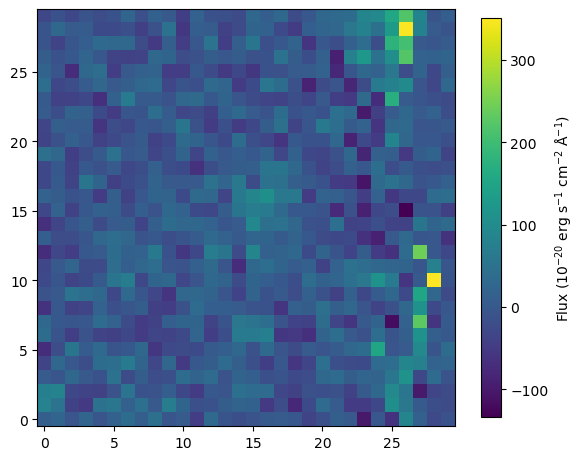

(30, 30)
(30, 30)


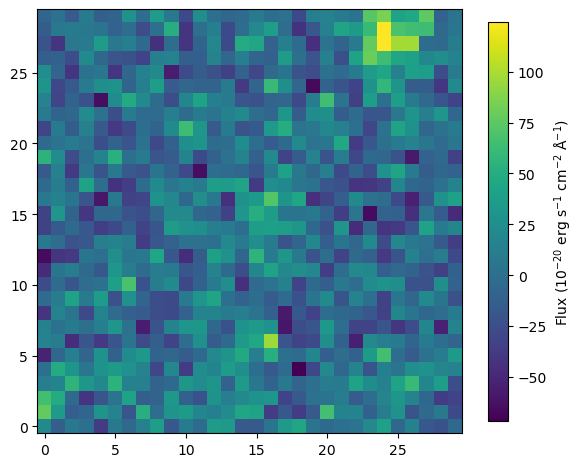

In [33]:
print(stacked_images['image_1'].shape)
print(stacked_images['image_2'].shape)

stacks = [stacked_images['image_1'], stacked_images['image_2']]
# Stack the images by adding their flux values
combined_image = np.sum(stacks, axis=0)


# Plot the stacked 2D image with RMS scaling
plt.figure(figsize=(6, 6))
im = plt.imshow(combined_image, origin='lower', cmap='viridis')
cbar = plt.colorbar(im, label=r'Flux (10$^{-20}$ erg s$^{-1}$ cm$^{-2}$ Å$^{-1}$)', shrink=0.7)

#plt.gca().invert_xaxis()  # RA decreases to the right
plt.tight_layout()
plt.show()



In [67]:
# Example source index from the mosaic catalog
source_list = np.linspace(0, 30, 29, dtype=int)

# Initialize dictionaries to store the outputs
stacked_images = {}
spectrum_data_dict = {}
spectrum_wave_rest_dict = {}

for i, source in enumerate(source_list):
    # Load source details from the mosaic catalog
    NIRSpec_ID = mosaic['NIRSpec_ID'][source]
    ra_center = mosaic['RA'][source]    
    dec_center = mosaic['DEC'][source]
    redshift = mosaic['z_Spec'][source]  
    rest_wavelength_range = (1200, 1230)  # Example rest wavelength range in Angstroms
    spatial_extent = 3  # Spatial extent in arcseconds

    # Filepath to the MUSE data cube FITS file
    filepath = '/Users/s2537809/MUSE/DATACUBE_UDF-MOSAIC.fits'

    # Extract the source for each source in source list
    stacked_image, spectrum_data, spectrum_wave_rest = extract_source(
        filepath, ra_center, dec_center, redshift, rest_wavelength_range, spatial_extent, NIRSpec_ID, smoothing_sigma=5
    )
    
    # Store the results in the dictionaries with unique keys
    stacked_images[f'image_{i+1}'] = stacked_image
    spectrum_data_dict[f'data_{i+1}'] = spectrum_data
    spectrum_wave_rest_dict[f'wave_rest_{i+1}'] = spectrum_wave_rest

print(stacked_images['image_1'])
print(spectrum_data_dict['data_1'])




Astropy pixel coordinates: (84.47665031689348, 374.30581651117024)
RA/Dec input (ra, dec): (53.1749000549316, -27.8058967590332)
RA: 53.174900054931605, Dec: -27.805896759033196
Rest wavelength range: (1200, 1230)
Redshift: 4.281985
Cube wavelength range: 4750.0 9350.0
Requested wavelength range: 6338.382 6496.841549999999


TypeError: unsupported operand type(s) for +: 'NoneType' and 'int'

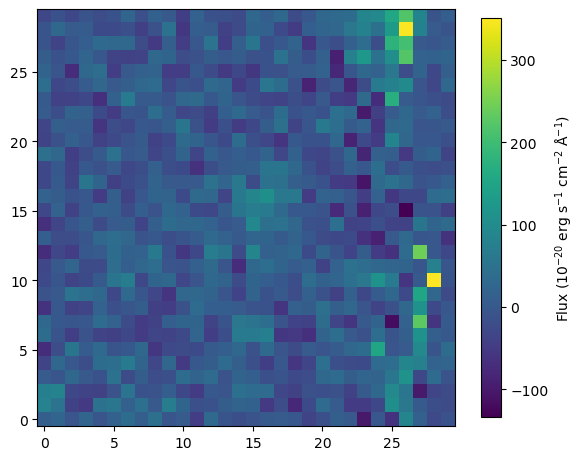

In [36]:



all_stacked_images = []

for key in stacked_images:
    all_stacked_images.append(stacked_images[key])

# Sum all the stacked images
combined_image = np.sum(all_stacked_images, axis=0)

# Plot the combined stacked 2D image with RMS scaling
plt.figure(figsize=(6, 6))
im = plt.imshow(combined_image, origin='lower', cmap='viridis')
cbar = plt.colorbar(im, label=r'Flux (10$^{-20}$ erg s$^{-1}$ cm$^{-2}$ Å$^{-1}$)', shrink=0.7)

plt.tight_layout()
plt.show()

In [27]:
print(spectrum_wave_rest)

[1199.91068253 1200.154666   1200.39864946 1200.64263293 1200.88661639
 1201.13059986 1201.37458333 1201.61856679 1201.86255026 1202.10653372
 1202.35051719 1202.59450065 1202.83848412 1203.08246758 1203.32645105
 1203.57043451 1203.81441798 1204.05840144 1204.30238491 1204.54636837
 1204.79035184 1205.03433531 1205.27831877 1205.52230224 1205.7662857
 1206.01026917 1206.25425263 1206.4982361  1206.74221956 1206.98620303
 1207.23018649 1207.47416996 1207.71815342 1207.96213689 1208.20612035
 1208.45010382 1208.69408729 1208.93807075 1209.18205422 1209.42603768
 1209.67002115 1209.91400461 1210.15798808 1210.40197154 1210.64595501
 1210.88993847 1211.13392194 1211.3779054  1211.62188887 1211.86587233
 1212.1098558  1212.35383927 1212.59782273 1212.8418062  1213.08578966
 1213.32977313 1213.57375659 1213.81774006 1214.06172352 1214.30570699
 1214.54969045 1214.79367392 1215.03765738 1215.28164085 1215.52562431
 1215.76960778 1216.01359125 1216.25757471 1216.50155818 1216.74554164
 1216.9

(30, 30)
(30, 30)
(30, 30)


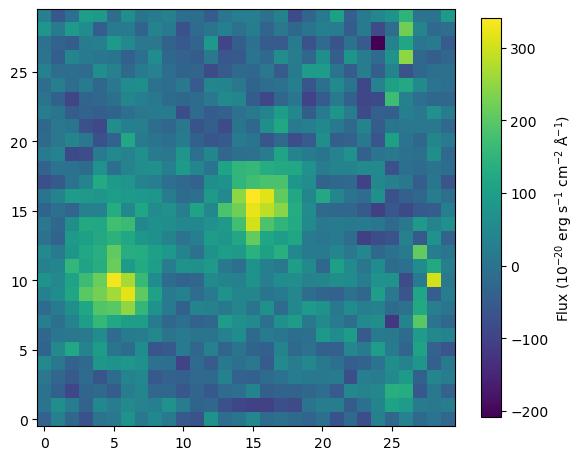

In [70]:
print(stacked_image_1.shape)
print(stacked_image_2.shape)

stacks = [stacked_image_1, stacked_image_2, stacked_image_3, stacked_image_4, stacked_image_5, stacked_image_6, stacked_image_7, stacked_image_8, stacked_image_9]

# Stack the images by adding their flux values
combined_image = np.sum(stacks, axis=0)

# Combne the Spectra
combined_spectrum = np.mean([spectrum_1, spectrum_2, spectrum_3, spectrum_4, spectrum_5, spectrum_6, spectrum_7, spectrum_8, spectrum_9], axis=0)

print(combined_image.shape)  # Should still be (30, 30)

# Plot the stacked 2D image with RMS scaling
plt.figure(figsize=(6, 6))
im = plt.imshow(combined_image, origin='lower', cmap='viridis')
cbar = plt.colorbar(im, label=r'Flux (10$^{-20}$ erg s$^{-1}$ cm$^{-2}$ Å$^{-1}$)', shrink=0.7)

#plt.gca().invert_xaxis()  # RA decreases to the right
plt.tight_layout()
plt.show()

# Plot the 1D spectrum
    plt.figure(figsize=(12, 4))
    plt.plot(combined_spectrum, spectrum_data, color='green', alpha=0.4, label='Source Spectrum')
    plt.xlabel(r'Restframe Wavelength (Å)', fontsize=12)
    plt.ylabel(r'Flux (10$^{-20}$ erg s$^{-1}$ cm$^{-2}$ Å$^{-1}$)', fontsize=12)
    plt.title(f'Spectrum of Source {NIRSpec_ID} at z_spec={redshift:.3f}', fontsize=12, pad=10)
    plt.minorticks_on()
    plt.tick_params(axis='both', which='both', direction='in', length=8, width=1, colors='black', grid_color='black', grid_alpha=0.5)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()


Astropy pixel coordinates: (858.1998872275186, 121.1934561833511)
RA/Dec input (ra, dec): (53.1281547546387, -27.7875804901123)
RA: 53.12815475463869, Dec: -27.78758049011229
Rest wavelength range: (1200, 1230)
Redshift: 5.486001
Cube wavelength range: 4750.0 9350.0
Requested wavelength range: 7783.2011999999995 7977.78123
RA/Dec at center of image (input): 53.128, -27.788
RA/Dec at center of image (wcs): [ 53.12815595 -27.78759591]
Min value: -65.39447919186205
Max value: 116.78743222914636
Mean value: 3.3482431374277803
RMS: 23.25737564428416


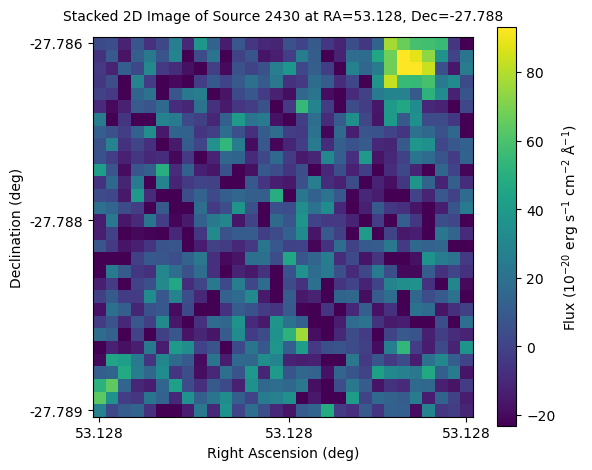

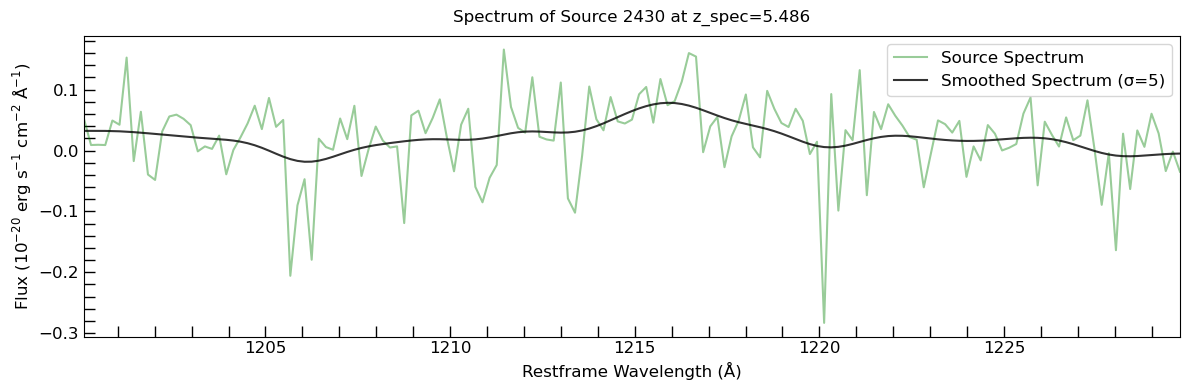

AttributeError: 'NoneType' object has no attribute 'coord'

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from mpdaf.obj import Spectrum

# Example list of source indices from the mosaic catalog
source_indices = [0, 1, 2, 3]  # Replace with the actual indices you want to process

# Filepath to the MUSE data cube FITS file
filepath = '/Users/s2537809/MUSE/DATACUBE_UDF-MOSAIC.fits'

# Initialize lists to store stacked images and spectra
stacked_images = []
all_spectra = []

# Define a common wavelength grid for spectra stacking (adjust this range if needed)
common_wavelength_grid = np.linspace(4750, 9350, 1000)  # Create a common wavelength grid

# Loop through the selected sources
for source in source_indices:
    # Load source details from the mosaic catalog
    NIRSpec_ID = mosaic['NIRSpec_ID'][source]
    ra_center = mosaic['RA'][source]    
    dec_center = mosaic['DEC'][source]
    redshift = mosaic['z_Spec'][source]  
    rest_wavelength_range = (1200, 1230)  # Example rest wavelength range in Angstroms
    spatial_extent = 3  # Spatial extent in arcseconds

    # Call the updated function to extract the 2D stacked image and 1D spectrum
    stacked_image, spectrum = extract_source(filepath, ra_center, dec_center, redshift, rest_wavelength_range, spatial_extent, NIRSpec_ID, smoothing_sigma=5)

    # Append valid images to the list for stacking
    if stacked_image is not None:
        stacked_images.append(stacked_image)

    # Check if the spectrum is valid
    if spectrum is not None and spectrum.data is not None:
        # Interpolate the spectrum to the common wavelength grid
        spectrum_interp = interp1d(spectrum.wave.coord(), spectrum.data, bounds_error=False, fill_value=np.nan)
        interpolated_spectrum = spectrum_interp(common_wavelength_grid)
        
        # Append interpolated spectrum
        all_spectra.append(interpolated_spectrum)
    else:
        print(f"Warning: Spectrum for source {NIRSpec_ID} is None or invalid and will be skipped.")

# Stack the images using a median stack
if len(stacked_images) > 0:
    # Convert to masked arrays to handle NaNs or invalid values
    stacked_images = np.ma.masked_invalid(stacked_images)
    final_stacked_image = np.ma.median(stacked_images, axis=0)
else:
    print("No valid images were found to stack.")
    final_stacked_image = None

# Stack the spectra using a median stack
if len(all_spectra) > 0:
    # Convert to masked arrays to handle NaNs or invalid values
    all_spectra = np.ma.masked_invalid(all_spectra)
    final_combined_spectrum = np.ma.median(all_spectra, axis=0)
else:
    print("No valid spectra were found to stack.")
    final_combined_spectrum = None

# Plot the final stacked 2D image
if final_stacked_image is not None:
    plt.figure(figsize=(6, 6))
    im = plt.imshow(final_stacked_image, origin='lower', cmap='viridis')
    plt.colorbar(label='Flux (10$^{-20}$ erg s$^{-1}$ cm$^{-2}$ Å$^{-1}$)')
    plt.title('Final Stacked 2D Image (Median)')
    plt.xlabel('X Pixel')
    plt.ylabel('Y Pixel')
    plt.tight_layout()
    plt.show()

# Plot the combined spectrum
if final_combined_spectrum is not None:
    plt.figure(figsize=(12, 4))
    plt.plot(common_wavelength_grid, final_combined_spectrum, color='green', alpha=0.6, label='Combined Spectrum (Median)')
    plt.xlim([common_wavelength_grid[0], common_wavelength_grid[-1]])  # Ensure it touches both ends
    plt.xlabel('Restframe Wavelength (Å)')
    plt.ylabel('Flux (10$^{-20}$ erg s$^{-1}$ cm$^{-2}$ Å$^{-1}$)')
    plt.title('Combined Spectrum (Median)')
    plt.minorticks_on()
    plt.legend()
    plt.tight_layout()
    plt.show()



Astropy pixel coordinates: (858.1998872275186, 121.1934561833511)
RA/Dec input (ra, dec): (53.1281547546387, -27.7875804901123)
RA: 53.12815475463869, Dec: -27.78758049011229
Rest wavelength range: (1200, 1230)
Redshift: 5.486001
Cube wavelength range: 4750.0 9350.0
Requested wavelength range: 7783.2011999999995 7977.78123
RA/Dec at center of image (input): 53.128, -27.788
RA/Dec at center of image (wcs): [ 53.12815595 -27.78759591]
Min value: -65.39447919186205
Max value: 116.78743222914636
Mean value: 3.3482431374277803
RMS: 23.25737564428416


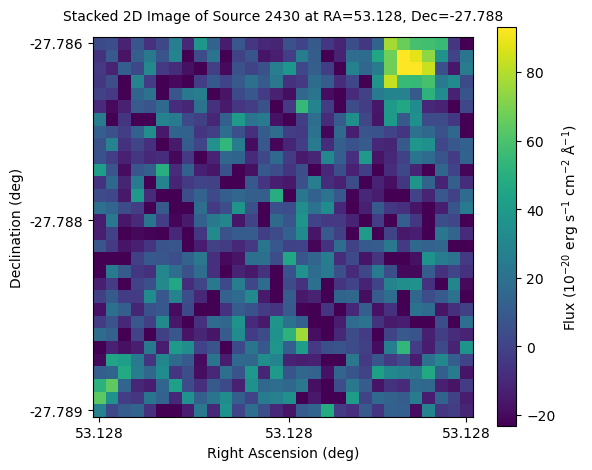

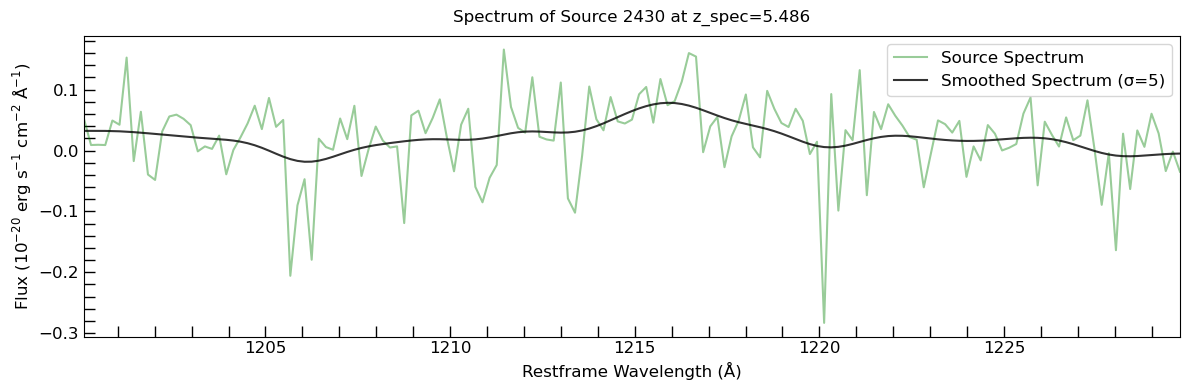

AttributeError: 'NoneType' object has no attribute 'coord'

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from mpdaf.obj import Spectrum

# Example list of source indices from the mosaic catalog
source_indices = [0, 1, 2, 3]  # Replace with the actual indices you want to process

# Filepath to the MUSE data cube FITS file
filepath = '/Users/s2537809/MUSE/DATACUBE_UDF-MOSAIC.fits'

# Initialize lists to store stacked images and spectra
stacked_images = []
all_spectra = []

# Define a common wavelength grid for spectra stacking (adjust this range if needed)
common_wavelength_grid = np.linspace(4750, 9350, 1000)  # Create a common wavelength grid

# Loop through the selected sources
for source in source_indices:
    # Load source details from the mosaic catalog
    NIRSpec_ID = mosaic['NIRSpec_ID'][source]
    ra_center = mosaic['RA'][source]    
    dec_center = mosaic['DEC'][source]
    redshift = mosaic['z_Spec'][source]  
    rest_wavelength_range = (1200, 1230)  # Example rest wavelength range in Angstroms
    spatial_extent = 3  # Spatial extent in arcseconds

    # Call the updated function to extract the 2D stacked image and 1D spectrum
    stacked_image, spectrum = extract_source(filepath, ra_center, dec_center, redshift, rest_wavelength_range, spatial_extent, NIRSpec_ID, smoothing_sigma=5)

    # Append valid images to the list for stacking
    if stacked_image is not None:
        stacked_images.append(stacked_image)

    # Check if the spectrum is valid
    if spectrum is not None and spectrum.data is not None:
        # Interpolate the spectrum to the common wavelength grid
        spectrum_interp = interp1d(spectrum.wave.coord(), spectrum.data, bounds_error=False, fill_value=np.nan)
        interpolated_spectrum = spectrum_interp(common_wavelength_grid)
        
        # Append interpolated spectrum
        all_spectra.append(interpolated_spectrum)
    else:
        print(f"Warning: Spectrum for source {NIRSpec_ID} is None or invalid and will be skipped.")

# Stack the images using a median stack
if len(stacked_images) > 0:
    # Convert to masked arrays to handle NaNs or invalid values
    stacked_images = np.ma.masked_invalid(stacked_images)
    final_stacked_image = np.ma.median(stacked_images, axis=0)
else:
    print("No valid images were found to stack.")
    final_stacked_image = None

# Stack the spectra using a median stack
if len(all_spectra) > 0:
    # Convert to masked arrays to handle NaNs or invalid values
    all_spectra = np.ma.masked_invalid(all_spectra)
    final_combined_spectrum = np.ma.median(all_spectra, axis=0)
else:
    print("No valid spectra were found to stack.")
    final_combined_spectrum = None

# Plot the final stacked 2D image
if final_stacked_image is not None:
    plt.figure(figsize=(6, 6))
    im = plt.imshow(final_stacked_image, origin='lower', cmap='viridis')
    plt.colorbar(label='Flux (10$^{-20}$ erg s$^{-1}$ cm$^{-2}$ Å$^{-1}$)')
    plt.title('Final Stacked 2D Image (Median)')
    plt.xlabel('X Pixel')
    plt.ylabel('Y Pixel')
    plt.tight_layout()
    plt.show()

# Plot the combined spectrum
if final_combined_spectrum is not None:
    plt.figure(figsize=(12, 4))
    plt.plot(common_wavelength_grid, final_combined_spectrum, color='green', alpha=0.6, label='Combined Spectrum (Median)')
    plt.xlim([common_wavelength_grid[0], common_wavelength_grid[-1]])  # Ensure it touches both ends
    plt.xlabel('Restframe Wavelength (Å)')
    plt.ylabel('Flux (10$^{-20}$ erg s$^{-1}$ cm$^{-2}$ Å$^{-1}$)')
    plt.title('Combined Spectrum (Median)')
    plt.minorticks_on()
    plt.legend()
    plt.tight_layout()
    plt.show()


In [42]:
from astropy.coordinates import SkyCoord

# FK5 coordinates from DS9
coords_fk5 = "3:32:44.8478 -27:47:27.080"

# Convert to RA and Dec in degrees
coord = SkyCoord(coords_fk5, unit=(('hourangle', 'deg')), frame='fk5')

# Extract RA and Dec in degrees
ra_deg = coord.ra.deg
dec_deg = coord.dec.deg

print(ra_deg, dec_deg)


53.18686583333333 -27.790855555555556


In [ ]:
import matplotlib.pyplot as plt

# Flatten the image array to 1D for the histogram
flattened_image = stacked_image.flatten()

# Plot histogram of pixel values
plt.figure(figsize=(8, 5))
plt.hist(flattened_image, bins=100, color='blue', alpha=0.7)
plt.title('Pixel Value Distribution of Stacked 2D Image')
plt.xlabel('Pixel Value (Flux)')
plt.ylabel('Frequency')
plt.show()

from scipy.stats import skew

# Calculate skewness of the pixel value distribution
data_skewness = skew(flattened_image)
print(f"Skewness of the data: {data_skewness:.2f}")

# Print some basic statistics
print("Min pixel value:", np.min(flattened_image))
print("Max pixel value:", np.max(flattened_image))
print("Mean pixel value:", np.mean(flattened_image))
print("Median pixel value:", np.median(flattened_image))


In [11]:
# Define the file path
file_path_1 = '/Users/s2537809/MUSE/mosaic_jades_match'

file_path_2 = '/Users/s2537809/MUSE/jades_dr3_prism_public_gs_v1.1.fits'
# Load the catalog
cat3 = Table.read(file_path_1, format='fits')

cat4 = Table.read(file_path_2, format='fits')

jades =  cat4[cat4['z_Spec'] > 0]
mosaic = cat3[cat3['DATASET'] == 'MOSAIC']

mosaic = mosaic[mosaic['z_Spec'] > 0]
mosaic = mosaic[mosaic['LYALPHA_EMI_EQW'] < -50]

mosaic['NIRSpec_ID', 'RA', 'DEC', 'z_Spec', 'LYALPHA_EMI_EQW']

NIRSpec_ID,RA,DEC,z_Spec,LYALPHA_EMI_EQW
int64,float64,float64,float64,float32
2430,53.1281547546387,-27.7875804901123,5.486001,-112.028656
3034,53.1381149291992,-27.7946338653564,3.55318,-393.2935
3930,53.1732063293457,-27.7677803039551,3.505325,-62.71856
4009,53.1569442749023,-27.8161315917969,4.863714,-146.22449
5040,53.1679344177246,-27.8123321533203,2.98412,-173.17915
5321,53.1424942016602,-27.7703227996826,4.123298,-96.76109
5759,53.1494255065918,-27.8097324371338,5.0518938212794104,-168.05327
6519,53.1583213806152,-27.8072090148926,4.239049,-82.52317
7304,53.160816192627,-27.8044948577881,4.490012,-59.913383


In [28]:
jades

NIRSpec_ID,TIER,PID,Field,NIRCam_ID,RA_TARG,Dec_TARG,RA_NIRCam,Dec_NIRCam,Priority,z_Spec,z_Spec_flag,x_offset,y_offset,assigned_Prism,assigned_G140M,assigned_G235M,assigned_G395M,assigned_G395H,nDither_Pr,nDither_Gr,nInt_Prism,nInt_G140M,nInt_G235M,nInt_G395M,nInt_G395H,tExp_Prism,tExp_G140M,tExp_G235M,tExp_G395M,tExp_G395H,ObsDate,z_PRISM,PRISM_flux_flag,DR_flag,C4_1549_flux,C4_1549_err,Blnd_He2_O3_1650_flux,Blnd_He2_O3_1650_err,C3_1907_flux,C3_1907_err,Mg2_2796_flux,Mg2_2796_err,O2_3727_flux,O2_3727_err,Ne3_3869_flux,Ne3_3869_err,Ne3_3968_flux,Ne3_3968_err,HD_4102_flux,HD_4102_err,Blnd_HG_O3_flux,Blnd_HG_O3_err,HG_4340_flux,HG_4340_err,O3_4363_flux,O3_4363_err,Blnd_HB_O3_5007d_flux,Blnd_HB_O3_5007d_err,HB_4861_flux,HB_4861_err,O3_5007d_flux,O3_5007d_err,O3_4959_flux,O3_4959_err,O3_5007_flux,O3_5007_err,He1_5875_flux,He1_5875_err,O1_6300_flux,O1_6300_err,Blnd_HA_N2_S2_flux,Blnd_HA_N2_S2_err,HA_6563_flux,HA_6563_err,S2_6733d_flux,S2_6733d_err,He1_7065_flux,He1_7065_err,S3_9069_flux,S3_9069_err,S3_9532_flux,S3_9532_err,PaD_10049_flux,PaD_10049_err,He1_10829_flux,He1_10829_err,PaG_10938_flux,PaG_10938_err,PaB_12818_flux,PaB_12818_err,PaA_18751_flux,PaA_18751_err
,,,,,deg,deg,deg,deg,,,,arcsec,arcsec,,,,,,,,,,,,,,,,,,,,,,,1e-18 erg / (s cm2),,1e-18 erg / (s cm2),,1e-18 erg / (s cm2),,1e-18 erg / (s cm2),,1e-18 erg / (s cm2),,1e-18 erg / (s cm2),,1e-18 erg / (s cm2),,1e-18 erg / (s cm2),,1e-18 erg / (s cm2),,1e-18 erg / (s cm2),,1e-18 erg / (s cm2),,1e-18 erg / (s cm2),,1e-18 erg / (s cm2),,1e-18 erg / (s cm2),,1e-18 erg / (s cm2),,1e-18 erg / (s cm2),,1e-18 erg / (s cm2),,1e-18 erg / (s cm2),,1e-18 erg / (s cm2),,1e-18 erg / (s cm2),,1e-18 erg / (s cm2),,1e-18 erg / (s cm2),,1e-18 erg / (s cm2),,1e-18 erg / (s cm2),,1e-18 erg / (s cm2),,1e-18 erg / (s cm2),,1e-18 erg / (s cm2),,1e-18 erg / (s cm2),,1e-18 erg / (s cm2)
int64,bytes22,int64,bytes2,int64,float64,float64,float64,float64,float64,float64,bytes1,float64,float64,bytes1,bytes1,bytes1,bytes1,bytes1,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,bytes10,float64,bool,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
490,goods-s-mediumhst,1180,GS,-9999,53.178297,-27.815718,--,--,7.0,2.692,D,-0.043,-0.01,T,T,T,T,T,1,1,3,3,3,3,0,3107.4,3107.4,3107.4,3107.4,0.0,2022-10-05,2.698292,False,False,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,1.448930046870751,0.20,--,0.19,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
1176,goods-s-mediumhst,1180,GS,108298,53.174896,-27.805994,53.174896,-27.805996,7.0,4.281985,C,-0.049,0.033,T,T,T,T,T,1,1,3,3,3,3,0,3107.4,3107.4,3107.4,3107.4,0.0,2022-10-05,4.281985,False,False,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,0.928974565727539,0.15,--,0.14,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
1444,goods-s-mediumhst,1180,GS,110248,53.174507,-27.802980,53.174507,-27.802982,7.0,1.5968,C,0.081,0.051,T,T,T,T,T,1,1,3,3,3,3,0,3107.4,3107.4,3107.4,3107.4,0.0,2022-10-05,1.596800,False,True,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,2.10,--,1.37,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
1594,goods-s-mediumhst,1180,GS,111175,53.179156,-27.801472,53.179156,-27.801472,7.0,4.277382,C,0.013,-0.215,T,T,T,T,T,1,1,3,3,3,3,0,3107.4,3107.4,3107.4,3107.4,0.0,2022-10-05,4.277382,False,False,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,0.22,3.1092517557962203,0.32,--,--,--,--,-

In [66]:
def filter_sources_within_cube(filepath, catalog):
    """
    Filters sources in a catalog to include only those within the field of view of the MUSE data cube.

    Parameters:
    - filepath: Path to the MUSE FITS file (data cube)
    - catalog: Catalog containing 'RA_TARG' and 'Dec_TARG' columns (RA and Dec of sources)

    Returns:
    - filtered_catalog: Sources within the field of view of the data cube
    """
    
    # Load the FITS file and extract WCS using astropy
    with fits.open(filepath) as hdul:
        wcs = AstropyWCS(hdul[1].header)
        
        # Get cube shape in pixels (Ny, Nx)
        cube_shape = hdul[1].data.shape[1:3]
        Ny, Nx = cube_shape

        # Define the corners of the cube in pixel coordinates
        corners = [(0, 0), (Nx - 1, 0), (Nx - 1, Ny - 1), (0, Ny - 1)]
        
        # Use an arbitrary wavelength (e.g., central wavelength) from the cube's WCS
        wavelength = wcs.wcs.crval[2]  # Use the CRVAL3 value (reference wavelength)

        # Add the wavelength to the pixel corners (x, y, lambda)
        corners_with_wavelength = [(x, y, wavelength) for x, y in corners]

        # Convert pixel corners to RA/Dec using WCS (3D: x, y, wavelength)
        world_coords = wcs.wcs_pix2world(corners_with_wavelength, 0)

    # Extract RA/Dec boundaries outside the `with` block since the file is now closed
    ra_corners = world_coords[:, 0]
    dec_corners = world_coords[:, 1]

    # Get the RA/Dec range from the cube corners
    ra_min, ra_max = min(ra_corners), max(ra_corners)
    dec_min, dec_max = min(dec_corners), max(dec_corners)

    print(f"RA range: {ra_min:.3f} to {ra_max:.3f}")
    print(f"Dec range: {dec_min:.3f} to {dec_max:.3f}")

    # Filter the catalog based on RA/Dec bounds
    filtered_catalog = catalog[
        (catalog['RA_TARG'] >= ra_min) &
        (catalog['RA_TARG'] <= ra_max) &
        (catalog['Dec_TARG'] >= dec_min) &
        (catalog['Dec_TARG'] <= dec_max)
    ]

    return filtered_catalog

# Filepath to the MUSE data cube FITS file
filepath = '/Users/s2537809/MUSE/DATACUBE_UDF-MOSAIC.fits'

# Filter the jades catalog based on the cube's FoV
filtered_jades = filter_sources_within_cube(filepath, jades)

filtered_jades

RA range: 53.119 to 53.203
Dec range: -27.824 to -27.750


NIRSpec_ID,TIER,PID,Field,NIRCam_ID,RA_TARG,Dec_TARG,RA_NIRCam,Dec_NIRCam,Priority,z_Spec,z_Spec_flag,x_offset,y_offset,assigned_Prism,assigned_G140M,assigned_G235M,assigned_G395M,assigned_G395H,nDither_Pr,nDither_Gr,nInt_Prism,nInt_G140M,nInt_G235M,nInt_G395M,nInt_G395H,tExp_Prism,tExp_G140M,tExp_G235M,tExp_G395M,tExp_G395H,ObsDate,z_PRISM,PRISM_flux_flag,DR_flag,C4_1549_flux,C4_1549_err,Blnd_He2_O3_1650_flux,Blnd_He2_O3_1650_err,C3_1907_flux,C3_1907_err,Mg2_2796_flux,Mg2_2796_err,O2_3727_flux,O2_3727_err,Ne3_3869_flux,Ne3_3869_err,Ne3_3968_flux,Ne3_3968_err,HD_4102_flux,HD_4102_err,Blnd_HG_O3_flux,Blnd_HG_O3_err,HG_4340_flux,HG_4340_err,O3_4363_flux,O3_4363_err,Blnd_HB_O3_5007d_flux,Blnd_HB_O3_5007d_err,HB_4861_flux,HB_4861_err,O3_5007d_flux,O3_5007d_err,O3_4959_flux,O3_4959_err,O3_5007_flux,O3_5007_err,He1_5875_flux,He1_5875_err,O1_6300_flux,O1_6300_err,Blnd_HA_N2_S2_flux,Blnd_HA_N2_S2_err,HA_6563_flux,HA_6563_err,S2_6733d_flux,S2_6733d_err,He1_7065_flux,He1_7065_err,S3_9069_flux,S3_9069_err,S3_9532_flux,S3_9532_err,PaD_10049_flux,PaD_10049_err,He1_10829_flux,He1_10829_err,PaG_10938_flux,PaG_10938_err,PaB_12818_flux,PaB_12818_err,PaA_18751_flux,PaA_18751_err
,,,,,deg,deg,deg,deg,,,,arcsec,arcsec,,,,,,,,,,,,,,,,,,,,,,,1e-18 erg / (s cm2),,1e-18 erg / (s cm2),,1e-18 erg / (s cm2),,1e-18 erg / (s cm2),,1e-18 erg / (s cm2),,1e-18 erg / (s cm2),,1e-18 erg / (s cm2),,1e-18 erg / (s cm2),,1e-18 erg / (s cm2),,1e-18 erg / (s cm2),,1e-18 erg / (s cm2),,1e-18 erg / (s cm2),,1e-18 erg / (s cm2),,1e-18 erg / (s cm2),,1e-18 erg / (s cm2),,1e-18 erg / (s cm2),,1e-18 erg / (s cm2),,1e-18 erg / (s cm2),,1e-18 erg / (s cm2),,1e-18 erg / (s cm2),,1e-18 erg / (s cm2),,1e-18 erg / (s cm2),,1e-18 erg / (s cm2),,1e-18 erg / (s cm2),,1e-18 erg / (s cm2),,1e-18 erg / (s cm2),,1e-18 erg / (s cm2),,1e-18 erg / (s cm2),,1e-18 erg / (s cm2)
int64,bytes22,int64,bytes2,int64,float64,float64,float64,float64,float64,float64,bytes1,float64,float64,bytes1,bytes1,bytes1,bytes1,bytes1,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,bytes10,float64,bool,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
416,goods-s-mediumhst,1180,GS,100206,53.157983,-27.817070,53.157990,-27.817066,8.0,-1.0,E,-0.016,-0.161,T,F,F,F,F,1,0,3,0,0,0,0,3107.4,0.0,0.0,0.0,0.0,2022-10-05,--,False,False,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
455,goods-s-mediumhst,1180,GS,197744,53.171946,-27.816423,53.171950,-27.816409,7.0,-1.0,E,0.069,-0.184,T,T,T,T,T,1,1,3,3,3,3,0,3107.4,3107.4,3107.4,3107.4,0.0,2022-10-05,--,False,False,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
490,goods-s-mediumhst,1180,GS,-9999,53.178297,-27.815718,--,--,7.0,2.692,D,-0.043,-0.01,T,T,T,T,T,1,1,3,3,3,3,0,3107.4,3107.4,3107.4,3107.4,0.0,2022-10-05,2.698292,False,False,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,1.448930046870751,0.20,--,0.19,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
500,goods-s-mediumhst,1180,GS,101426,53.165971,-27.815537,53.165970,-27.815526,7.6,-1.0,E,0.086,0.135,T,F,F,F,F,1,0,3,0,0,0,0,3107.4,0.0,0.0,0.0,0.0,2022-10-05,--,False,True,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--
507,goods-s-me

Astropy pixel coordinates: (83.34873579650777, 372.95640351483297)
RA/Dec input (ra, dec): (53.174896, -27.8059944)
RA: 53.174896, Dec: -27.805994399999996
Rest wavelength range: (1200, 1230)
Redshift: 4.281985
Cube wavelength range: 4750.0 9350.0
Requested wavelength range: 6338.382 6496.841549999999
RA/Dec at center of image (input): 53.175, -27.806
RA/Dec at center of image (wcs): [ 53.17487209 -27.80604685]
Min value: -39.985101343132555
Max value: 36.675510325003415
Mean value: -0.7469091995399342
RMS: 12.531732233515234


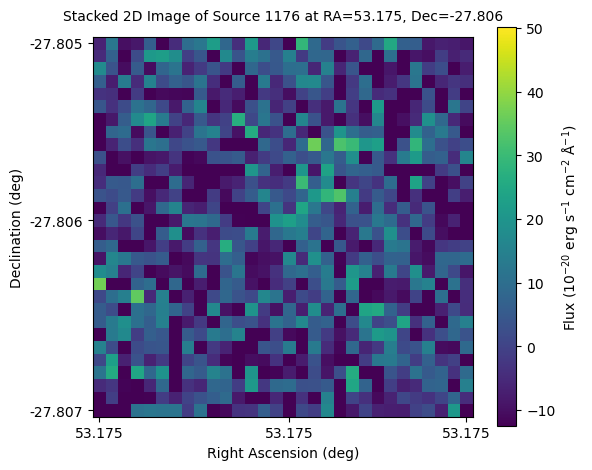

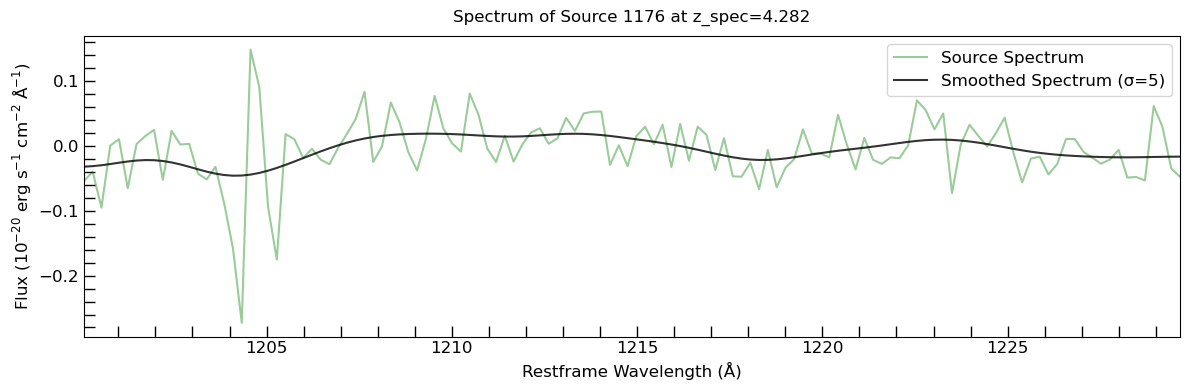

In [32]:
# Example source index from the mosaic catalog
source = 1


# Load source details from the mosaic catalog
NIRSpec_ID = jades['NIRSpec_ID'][source]
ra_center = jades['RA_TARG'][source]    
dec_center = jades['Dec_TARG'][source]
redshift = jades['z_Spec'][source]  
rest_wavelength_range = (1200, 1230)  # Example rest wavelength range in Angstroms
spatial_extent = 3 # Spatial extent in arcseconds

# Filepath to the MUSE data cube FITS file
filepath = '/Users/s2537809/MUSE/DATACUBE_UDF-MOSAIC.fits'

# Call the updated function to extract the 2D stacked image and 1D spectrum
stacked_image, spectrum = extract_source(filepath, ra_center, dec_center, redshift, rest_wavelength_range, spatial_extent, NIRSpec_ID, smoothing_sigma=5)


NIRSpec_ID,RA,DEC,z_Spec,LYALPHA_EMI_EQW
int64,float64,float64,float64,float32
2430,53.1281547546387,-27.7875804901123,5.486001,-112.028656
5759,53.1494255065918,-27.8097324371338,5.0518938212794104,-168.05327
9365,53.1627883911133,-27.7607803344727,5.92086,-145.68391
9821,53.1510887145996,-27.7829303741455,5.263018,-74.93732
17400,53.1500396728516,-27.7763271331787,13.2,-709.53955
19606,53.1765403747559,-27.7710266113281,5.889135587136734,-146.0922
42905,53.1406898498535,-27.8021564483643,5.916362454154224,-172.10515
53419,53.1856956481934,-27.774450302124,5.387092,-83.77498
201906,53.14562898,-27.80142611,5.520044,-66.83434


In [22]:
cube.wcs.get_axis_increments()

array([ 5.55555556e-05, -5.55555556e-05])

In [286]:
cube.wcs.get_rot()

-41.99999999999992

In [288]:
from astropy.io import fits
from astropy.wcs import WCS
import numpy as np

# Load the FITS file
with fits.open('/Users/s2537809/MUSE/DATACUBE_UDF-MOSAIC.fits') as hdul:
    # Assuming the WCS is in the primary header
    wcs = WCS(hdul[0].header)
    print(hdul[0].header)
# Example RA/Dec coordinates
ra = 53.177  # Right Ascension in degrees
dec = -27.769  # Declination in degrees

# Convert RA/Dec to pixel coordinates
# WCS expects coordinates in (RA, Dec) order
pixel_coords = wcs.wcs_world2pix(ra, dec, 0)  # The third argument is the frame index (0 for the first frame)

print(f"Pixel coordinates: {pixel_coords}")


SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                    8 / array data type                                NAXIS   =                    0 / number of array dimensions                     EXTEND  =                    T                                                  ORIGIN  = 'ESO-PARANAL'        / European Southern Observatory                  TELESCOP= 'ESO-VLT-U4'         / ESO <TEL>                                      INSTRUME= 'MUSE    '           / Instrument used.                               RA      =             53.15947 / offset applied!                                DEC     =            -27.76496 / offset applied!                                EQUINOX =               2000.0 / Standard FK5                                   RADECSYS= 'FK5     '           / Coordinate system                              EXPTIME =              36000.0 / Integration time                               MJD-OBS =       56925.22972735 / Obs sta

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


In [302]:
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS

# Load the FITS file
with fits.open('/Users/s2537809/MUSE/DATACUBE_UDF-MOSAIC.fits') as hdul:
    wcs = WCS(hdul[1].header)

# Example RA/Dec coordinates
ra = 53.1777585  # Right Ascension in degrees
dec = -27.7699374  # Declination in degrees

# Use the reference wavelength (CRVAL3 from the header)
wavelength = 4750  # Reference wavelength in Angstroms

# Convert RA/Dec/Wavelength to pixel coordinates
pixel_coords = wcs.wcs_world2pix(np.array([[ra, dec, wavelength]]), 0)

# Extract pixel coordinates (ignore the wavelength)
pixel_x, pixel_y, _ = pixel_coords[0]

print(f"Pixel coordinates: ({pixel_x}, {pixel_y})")

# Convert pixel coordinates to RA/Dec using pixel_x, pixel_y, and wavelength
world_coords = wcs.wcs_pix2world(np.array([[pixel_x, pixel_y, wavelength]]), 0)

# Extract RA and Dec from the result
ra, dec, _ = world_coords[0]

print(f"RA: {ra}, Dec: {dec}")



Pixel coordinates: (483.7020502473711, 885.8210894995096)
RA: 53.1777585, Dec: -27.76993739999999


In [312]:

from mpdaf.obj import Cube

# Load the cube
cube = Cube('/Users/s2537809/MUSE/DATACUBE_UDF-MOSAIC.fits')

# Example RA/Dec coordinates
ra = 53.1777585  # Right Ascension in degrees
dec = -27.7699374  # Declination in degrees

# Use the reference wavelength (CRVAL3 from the header)
wavelength = 4750  # Reference wavelength in Angstroms

# Convert RA/Dec to pixel coordinates using cube.wcs.sky2pix
pix_coords = cube.wcs.sky2pix([[dec, ra]], unit='deg')[0]
print(f"Pixel coordinates: {pix_coords}")

x_center, y_center = pix_coords[0], pix_coords[1]

print(f"Pixel coordinates: ({x_center}, {y_center})")

world_coords = cube.wcs.pix2sky([[y_center, x_center]], unit="deg")[0]

# Extract RA and Dec from the result
dec, ra = world_coords

print(f"RA: {ra}, Dec: {dec}")

Pixel coordinates: [885.8210895  483.70205025]
Pixel coordinates: (885.8210894995096, 483.7020502473711)
RA: 53.14210127338599, Dec: -27.77159005571402


Pixel coordinates: [121.19345618 858.19988723]
RA/Dec input (ra, dec): (53.1281547546387, -27.7875804901123)
RA/Dec at (x_center, y_center): [-27.78456651  53.19351737]
RA/Dec at (0,0): [-27.78652798  53.19363411]


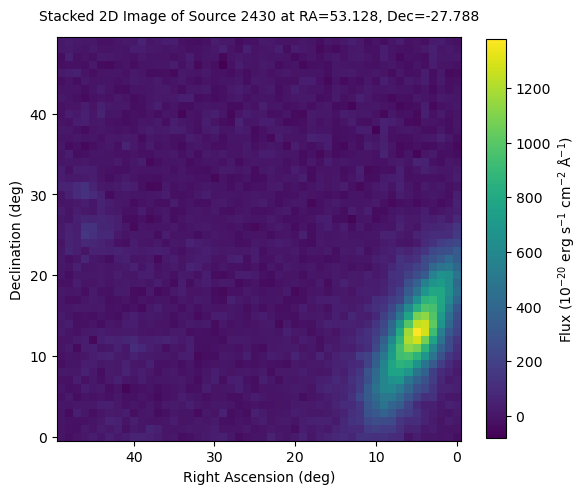

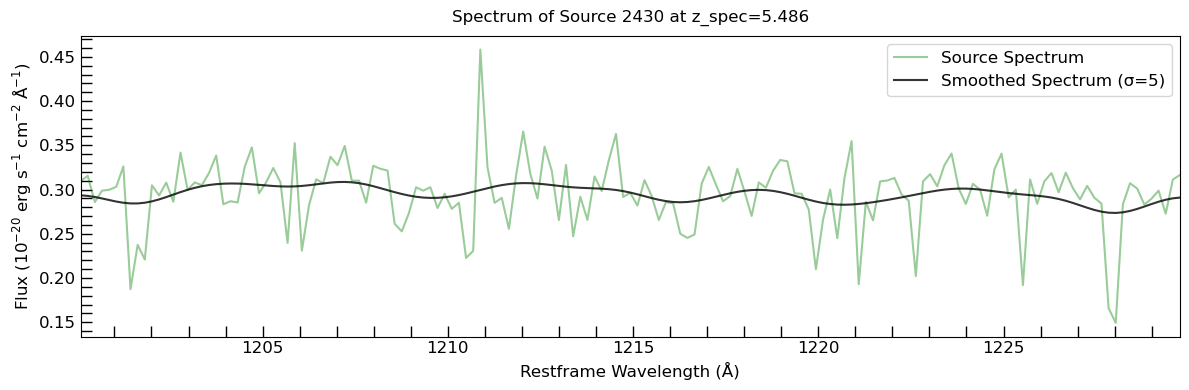

In [285]:
# Any source from mosaic (0-161)
source= 2


NIRSpec_ID = mosaic['NIRSpec_ID'][source]
ra_center = mosaic['RA'][source]    
dec_center = mosaic['DEC'][source]
redshift = mosaic['z_Spec'][source]  
rest_wavelength_range = (1200, 1230) 
spatial_extent  = 5 # arcseconds

# Call the function to extract the 2D stacked image and 1D spectrum
stacked_image, spectrum = extract_source(cube, ra_center, dec_center, redshift, rest_wavelength_range, spatial_extent, NIRSpec_ID,smoothing_sigma=5)



In [255]:
from astropy.wcs import WCS
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from mpdaf.obj import Spectrum
from scipy.ndimage import gaussian_filter1d

def extract_source(cube, ra, dec, redshift, rest_wavelength_range, spatial_extent, NIRSpec_ID, smoothing_sigma=3):
    """
    Extract a 2D stacked image and a 1D spectrum for a given source.
    Parameters are the same as before.
    """
    # Convert RA/Dec to pixel coordinates using cube.wcs.sky2pix
    pix_coords = cube.wcs.sky2pix([[dec, ra]], unit='deg')[0]
    print(f"Pixel coordinates: {pix_coords}")

    # Convert spatial extent to pixels using pixel scale from cube 
    spatial_extent_pixels = int(spatial_extent / cube.wcs.get_step(unit=u.arcsec)[1])

    if np.isnan(pix_coords).any():
        raise ValueError(f"Invalid RA/Dec coordinates: RA={ra}, Dec={dec} fall outside the cube field of view.")

    x_center, y_center = int(pix_coords[0]), int(pix_coords[1])

    # Calculate the observed wavelength range
    lambda_min_obs = rest_wavelength_range[0] * (1 + redshift)
    lambda_max_obs = rest_wavelength_range[1] * (1 + redshift)

    wave_start = np.argmin(np.abs(cube.wave.coord() - lambda_min_obs))
    wave_end = np.argmin(np.abs(cube.wave.coord() - lambda_max_obs))

    # Extract the subcube around the source in pixel coordinates
    x_slice = slice(x_center - spatial_extent_pixels, x_center + spatial_extent_pixels)
    y_slice = slice(y_center - spatial_extent_pixels, y_center + spatial_extent_pixels)

    x_slice = slice(max(0, x_slice.start), min(cube.shape[2], x_slice.stop))
    y_slice = slice(max(0, y_slice.start), min(cube.shape[1], y_slice.stop))

    subcube = cube[wave_start:wave_end, y_slice, x_slice]

    stacked_image = subcube.data.sum(axis=0)
    spectrum_data = subcube.data.mean(axis=(1, 2))

    if subcube.wave is not None:
        spectrum_wave = subcube.wave.coord()
        spectrum_wave = spectrum_wave / (1 + redshift)
    else:
        raise ValueError(f"Wave information missing for NIRSpec_ID={NIRSpec_ID}")

    ny, nx = stacked_image.shape
    x_pix = np.arange(nx)
    y_pix = np.arange(ny)

    dec_min, ra_min = cube.wcs.pix2sky([[y_pix[0], x_pix[0]]], unit='deg')[0]
    dec_max, ra_max = cube.wcs.pix2sky([[y_pix[-1], x_pix[-1]]], unit='deg')[0]

    # Plot the stacked 2D image with RA/Dec axis labels
    plt.figure(figsize=(6, 6))
    im = plt.imshow(stacked_image, origin='lower', cmap='viridis')
    cbar = plt.colorbar(im, label=r'Flux (10$^{-20}$ erg s$^{-1}$ cm$^{-2}$ Å$^{-1}$)', shrink=0.7) 
    cbar.ax.yaxis.set_offset_position('left')
    plt.title(f'Stacked 2D Image of Source {NIRSpec_ID} at RA={ra:.3f}, Dec={dec:.3f}', fontsize=10, pad=12)
    plt.xticks([0, nx//2, nx-1], [f'{ra_min:.3f}', f'{(ra_min + ra_max)/2:.3f}', f'{ra_max:.3f}'])
    plt.yticks([0, ny//2, ny-1], [f'{dec_min:.3f}', f'{(dec_min + dec_max)/2:.3f}', f'{dec_max:.3f}'])
    plt.xlabel('Right Ascension (deg)')
    plt.ylabel('Declination (deg)')
    plt.gca().invert_xaxis()
    plt.tight_layout()

    # Save the image plot to the PDF
    plt.savefig(pdf_pages, format='pdf')
    plt.close()

    smoothed_flux = gaussian_filter1d(spectrum_data, sigma=smoothing_sigma)

    # Plot the 1D spectrum
    plt.figure(figsize=(12, 4))
    plt.plot(spectrum_wave, spectrum_data, color='green', alpha=0.4, label='Source Spectrum')
    plt.plot(spectrum_wave, smoothed_flux, color='black', alpha=0.8, label=f'Smoothed Spectrum (σ={smoothing_sigma})')
    plt.xlim([spectrum_wave[0], spectrum_wave[-1]])  # Ensure the spectrum touches both ends
    plt.xlabel(r'Restframe Wavelength (Å)', fontsize=12)
    plt.ylabel(r'Flux (10$^{-20}$ erg s$^{-1}$ cm$^{-2}$ Å$^{-1}$)', fontsize=12)
    plt.title(f'Spectrum of Source {NIRSpec_ID} at z_spec={redshift:.3f}', fontsize=12, pad=10)
    plt.minorticks_on()
    plt.tick_params(axis='both', which='both', direction='in', length=8, width=1, colors='black', grid_color='black', grid_alpha=0.5)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize=12)
    plt.tight_layout()

    # Save the spectrum plot to the PDF
    plt.savefig(pdf_pages, format='pdf')
    plt.close()

    return stacked_image, Spectrum(lamb=spectrum_wave, flux=spectrum_data)


# Define the range of sources
source_indices = range(0, 161) 

# Open a PdfPages object to save plots
with PdfPages('sources_plots.pdf') as pdf_pages:
    for source in source_indices:
        try:
            NIRSpec_ID = mosaic['NIRSpec_ID'][source]
            ra_center = mosaic['RA_TARG'][source]
            dec_center = mosaic['Dec_TARG'][source]
            redshift = mosaic['z_Spec'][source]
            rest_wavelength_range = (800, 1600)
            spatial_extent = 5  # arcseconds

            # Call the function to extract the 2D stacked image and 1D spectrum
            stacked_image, spectrum = extract_source(cube, ra_center, dec_center, redshift, rest_wavelength_range, spatial_extent, NIRSpec_ID, smoothing_sigma=5)
        
        except Exception as e:
            print(f"Error processing NIRSpec_ID={mosaic['NIRSpec_ID'][source]}: {e}")



Pixel coordinates: [372.95640351  83.3487358 ]
Pixel coordinates: [478.83310378  87.39100586]
Pixel coordinates: [120.09382196 856.53735741]
Pixel coordinates: [132.54867406 653.6085749 ]
Pixel coordinates: [877.96618289 821.58068609]
Pixel coordinates: [ 99.50834334 101.50214097]
Pixel coordinates: [864.85708069 562.55905278]
Pixel coordinates: [ 45.15587337 170.46967132]
Pixel coordinates: [184.45252997  46.20694686]
Pixel coordinates: [ 46.23887656 198.52959159]
Pixel coordinates: [136.62181966 112.49046645]
Pixel coordinates: [160.79626669 111.06430829]
Pixel coordinates: [214.06237655  88.55461854]
Pixel coordinates: [130.38837818 382.85622146]
Pixel coordinates: [503.62594238 894.92005548]
Pixel coordinates: [ 83.3690219  125.89556922]
Error processing NIRSpec_ID=5669: Wave information missing for NIRSpec_ID=5669
Pixel coordinates: [141.145275    59.60297776]
Error processing NIRSpec_ID=5672: Wave information missing for NIRSpec_ID=5672
Pixel coordinates: [100.90608318 175.081464

Pixel coordinates: [877.96618289 821.58068609]


TypeError: cannot unpack non-iterable Figure object

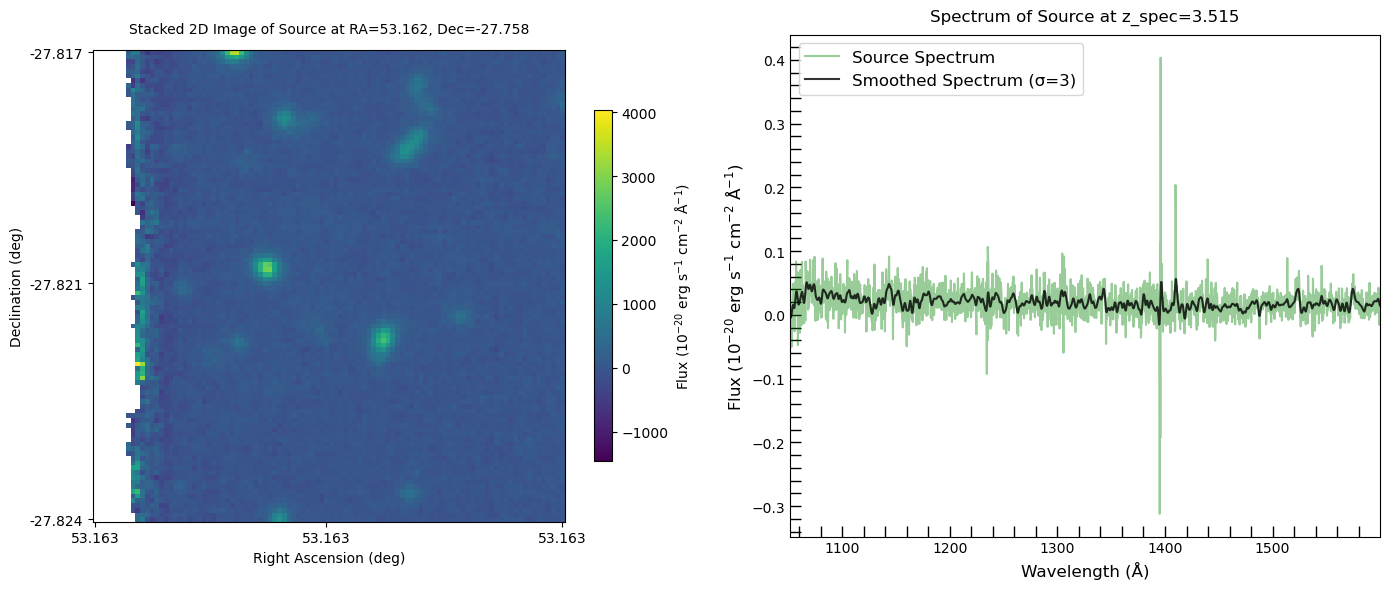

In [235]:
# Example input: using pixel coordinates directly
ra_center = 53.1616633 
dec_center = -27.7577022
redshift = 3.514951	  
rest_wavelength_range = (800, 1600) 
spatial_extent = 10

# Call the function to extract the 2D stacked image and 1D spectrum
stacked_image, spectrum = extract_source(cube, ra_center, dec_center, redshift, rest_wavelength_range, spatial_extent)



In [246]:
# Example input: using pixel coordinates directly
x_center = 150  # X pixel coordinate of the source
y_center = 120  # Y pixel coordinate of the source
redshift = 4  # Example redshift
rest_wavelength_range = (800, 1800)  # Example rest-frame wavelength range (in Angstroms)
spatial_extent = 5  # Spatial extent (half-box size in pixels)

# Call the function to extract the 2D stacked image and 1D spectrum
stacked_image, spectrum = extract_source_by_pixel(cube, x_center, y_center, redshift, rest_wavelength_range, spatial_extent)

# You can now visualize or analyze the `stacked_image` and `spectrum` outputs
# For example, plot the 2D image and 1D spectrum
plt.figure(figsize=(6, 6))
plt.imshow(stacked_image, origin='lower', cmap='viridis')
plt.colorbar(label='Flux (1e-20 erg / (Angstrom s cm2))')
plt.title('Stacked 2D Image of Source')
plt.xlabel('X (pixels)')
plt.ylabel('Y (pixels)')
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(spectrum, label='Source Spectrum')
plt.xlabel('Wavelength (Angstrom)')
plt.ylabel('Flux (1e-20 erg / (Angstrom s cm2))')
plt.title('Spectrum of Source')
plt.legend()
plt.show()



ValueError: too many values to unpack (expected 2)

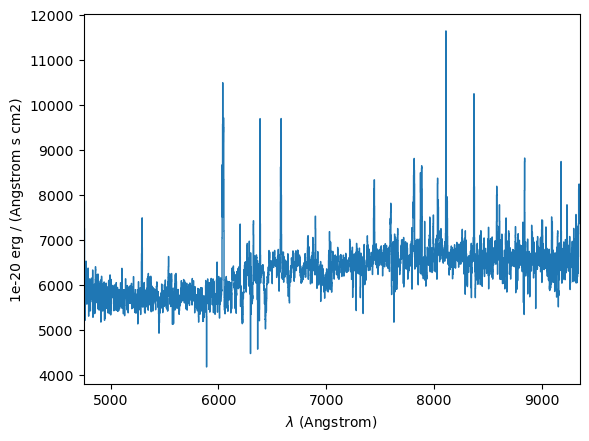

In [82]:
sp = cube.sum(axis=(1,2))
type(sp)

plt.figure()
sp.plot()

RA range: (-27.787713333300005, -27.7698785300293)
Dec range: (53.151058166638876, 53.1712788889)


In [51]:
cube[3000:,10:20,25:40].info()

[INFO] 681 x 10 x 15 Cube (/Users/s2537809/MUSE/DATACUBE_UDF-10.fits)
[INFO] .data(681 x 10 x 15) (1e-20 erg / (Angstrom s cm2)), .var(681 x 10 x 15)
[INFO] center:(-27:47:12.86794756,03:32:40.62465382) size:(2.000",3.000") step:(0.200",0.200") rot:-0.0 deg frame:FK5
[INFO] wavelength: min:8500.00 max:9350.00 step:1.25 Angstrom


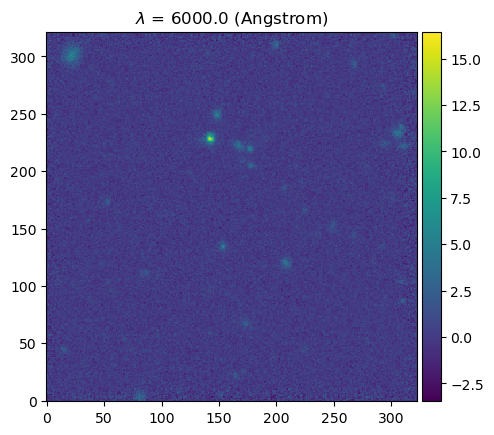

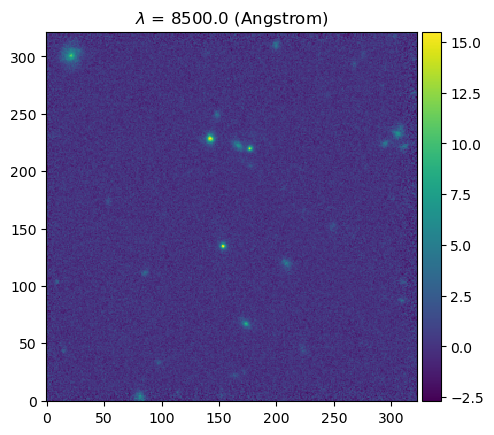

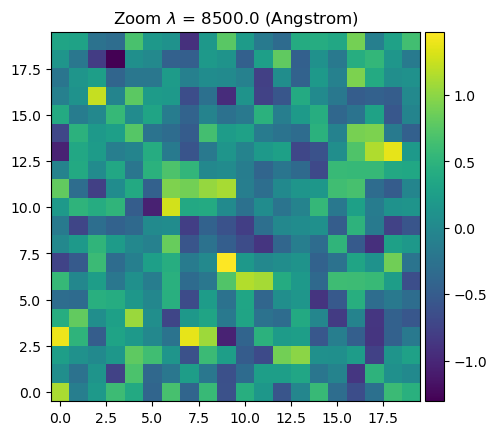

In [38]:
ima1 = cube[1000, :, :]
plt.figure()
ima1.plot(colorbar='v', title = '$\lambda$ = %.1f (%s)' %(cube.wave.coord(1000), cube.wave.unit))

ima2 = cube[3000, :, :]

plt.figure()

ima2.plot(colorbar='v', title = '$\lambda$ = %.1f (%s)' %(cube.wave.coord(3000), cube.wave.unit))


plt.figure()


ima2[5:25, 15:35].plot(colorbar='v',title = 'Zoom $\lambda$ = %.1f (%s)' %(cube.wave.coord(3000), cube.wave.unit))


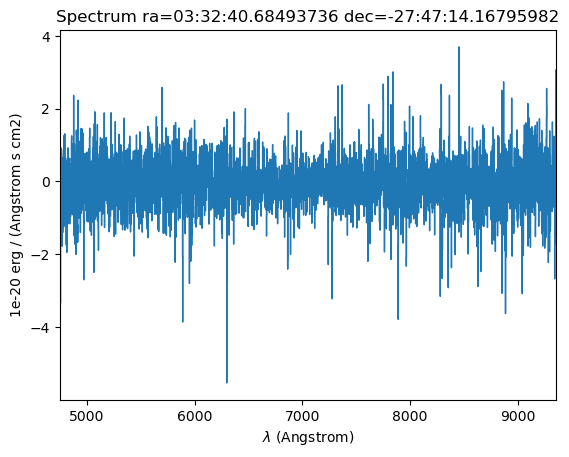

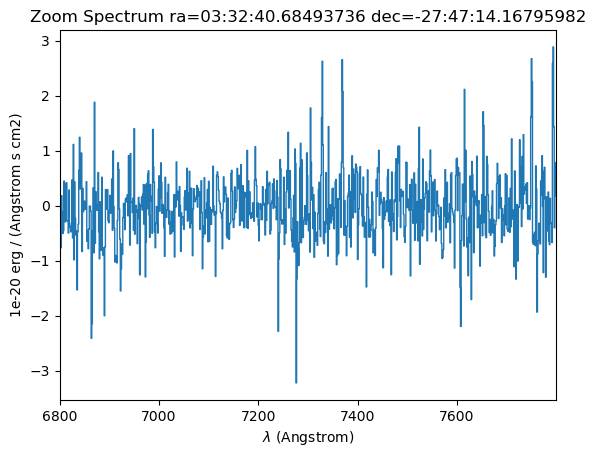

In [39]:
spe = cube[:, 8, 28]

import astropy.units as u

from mpdaf.obj import deg2sexa

coord_sky = cube.wcs.pix2sky([8, 28], unit=u.deg)

dec, ra = deg2sexa(coord_sky)[0]

plt.figure()


spe.plot(title = 'Spectrum ra=%s dec=%s' %(ra, dec))

plt.figure()


spe[1640:2440].plot(title = 'Zoom Spectrum ra=%s dec=%s' %(ra, dec))

In [44]:
print (cube.get_step(unit_wave=u.nm, unit_wcs=u.deg))

print(ima1.get_step(unit=u.deg))

print(spe.get_step(unit=u.angstrom))



[1.25000000e-01 5.55555556e-05 5.55555556e-05]
[5.55555556e-05 5.55555556e-05]
1.25


In [1]:
import scipy 

scipy.__version__

import mpdaf 

mpdaf.__version__

'3.6'

In [3]:
from mpdaf.sdetect import muselet
muselet('/Users/s2537809/MUSE/DATACUBE_UDF-10.fits')

[DEBUG] No exposure cube provided
[INFO] STEP 1: create white light, variance, RGB and narrow-band images
[INFO] creating broad-band images
[DEBUG] writing white light image: /Users/s2537809/MUSE/im_white.fits
[INFO] calculating weight image from variance cube
[DEBUG] writing weight image: /Users/s2537809/MUSE/im_weight.fits
[DEBUG] writing blue image: /Users/s2537809/MUSE/im_b.fits
[DEBUG] writing green image: /Users/s2537809/MUSE/im_g.fits
[DEBUG] writing red image: /Users/s2537809/MUSE/im_r.fits
[INFO] creating narrow-band images using 1 CPU


Created:3676/3676

[DEBUG] writing narrow-band cube: /Users/s2537809/MUSE/NB_DATACUBE_UDF-10.fits
[INFO] STEP 2: run SExtractor on broad-band and narrow-band images
[DEBUG] [/opt/homebrew/bin/sex] SExtractor version 2.28.0 (2023-03-11)
[INFO] running SExtractor on white light and RGB images
[DEBUG] combining catalogs
[INFO] 324 continiuum objects detected
[DEBUG] writing catalog: /Users/s2537809/MUSE/cat_bgr.dat
[INFO] running SExtractor on narrow-band images using 1 CPU


SExtractor:3676/3676

[INFO] STEP 3: merge SExtractor catalogs and measure redshifts
[DEBUG] excluding wavelengths between 5573.50Å and 5578.80Å
[DEBUG] excluding wavelengths between 6297.00Å and 6300.50Å
[DEBUG] 8 narrow-band layers will be excluded
[INFO] loading narrow-band catalogs using 1 CPU


Loaded:1033/3668

[WARNING] ID 5, not found in seg1040.fits


Loaded:1296/3668

[WARNING] ID 2, not found in seg1306.fits


Loaded:1450/3668

[WARNING] ID 2, not found in seg1460.fits


Loaded:2500/3668

[WARNING] ID 4, not found in seg2510.fits


Loaded:3053/3668

[WARNING] ID 2, not found in seg3063.fits


Loaded:3668/3668

[DEBUG] combining catalogs
[INFO] 3439 raw detections found


[INFO] cleaning detections with fluxes below 5σ
[INFO] 3439 detections remain (0 removed)
[INFO] cleaning detections at edge of cube
[INFO] 3439 detections remain (0 removed)
[INFO] cleaning below image weight 0.42142264544963837
[INFO] 3270 detections remain (169 removed)
[DEBUG] merging raw detections within Δr < 0.80″ and Δλ < 3.75Å
[INFO] 899 lines found (2371 duplicate detections discarded)
[DEBUG] grouping lines within Δr < 0.80″
[DEBUG] group assignment converged after 3 iterations
[INFO] 215 objects found
[DEBUG] writing raw catalog: /Users/s2537809/MUSE/cat_raw.fit
[DEBUG] writing cleaned catalog: /Users/s2537809/MUSE/cat_raw-clean.fit
[DEBUG] writing line catalog: /Users/s2537809/MUSE/cat_lines.fit
[DEBUG] writing object catalog: /Users/s2537809/MUSE/cat_objects.fit
[INFO] creating line source files using 1 CPU
[DEBUG] writing sources to: /Users/s2537809/MUSE/lines


Created:899/899

[INFO] creating line source catalog
[INFO] Building catalog from path /Users/s2537809/MUSE/lines


 100%

[DEBUG] writing catalog to: /Users/s2537809/MUSE/lines.fit


[INFO] creating object source files using 1 CPU
[DEBUG] creating file: /Users/s2537809/MUSE/emlines
[DEBUG] creating file: /Users/s2537809/MUSE/emlines_small
[DEBUG] writing sources to: /Users/s2537809/MUSE/objects


Created:215/215

[INFO] creating object source catalog
[INFO] Building catalog from path /Users/s2537809/MUSE/objects


 100%

[DEBUG] writing catalog to: /Users/s2537809/MUSE/objects.fit


In [ ]:
# open the objects.fit 
from mpdaf.obj import Cube


In [ ]:
from mpdaf.sdetect import Catalog
cat_lines = Catalog.read('lines.fit')
cat_objects = Catalog.read('objects.fit')

In [ ]:
from mpdaf.sdetect import SourceList
sources_lines = SourceList.from_path('lines')
sources_objects = SourceList.from_path('objects')

In [ ]:
from mpdaf.sdetect import Source
src_line = Source.from_file('lines/lines-0001.fits')
src_object = Source.from_file('objects/objects-0001.fits')

In [42]:
import astropy.units as u
from mpdaf.obj import Cube
from astropy.coordinates import SkyCoord

# Example RA and Dec in degrees
ra_input = 150.123  # right ascension in degrees
dec_input = 2.345   # declination in degrees

# Convert RA and Dec to pixel coordinates using the WCS of the cube
coord_sky = SkyCoord(ra=ra_input*u.deg, dec=dec_input*u.deg, frame='icrs')
pix_coords = cube.wcs.sky2pix([coord_sky.ra.deg, coord_sky.dec.deg])

# Extract pixel coordinates
x_pix, y_pix = int(pix_coords[0]), int(pix_coords[1])

# Extract the spectrum at the calculated pixel coordinates
spe = cube[:, y_pix, x_pix]

# Convert the sky coordinates back to sexagesimal format for labeling
dec, ra = deg2sexa([ra_input, dec_input])[0]

# Plot the full spectrum
plt.figure()
spe.plot(title='Spectrum ra=%s dec=%s' % (ra, dec))

# Plot a zoomed-in part of the spectrum (e.g., between indices 1640 and 2440)
plt.figure()
spe[1640:2440].plot(title='Zoom Spectrum ra=%s dec=%s' % (ra, dec))


TypeError: only size-1 arrays can be converted to Python scalars

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.io import fits
from astropy.wcs import WCS
from mpdaf.obj import Spectrum, Cube
from astropy.coordinates import SkyCoord
from astropy.convolution import convolve, Gaussian1DKernel

def load_cube(filename):
    """Load the MUSE data cube."""
    return Cube(filename)

def calculate_pixel_scale(header):
    """Calculate the pixel scale in arcseconds per pixel."""
    wcs = WCS(header)
    cd_matrix = wcs.wcs.cd
    pixel_scale_arcsec = (abs(cd_matrix[0, 0]) * u.deg).to(u.arcsec).value
    return pixel_scale_arcsec

# without float centers

def aperture_flux_extraction(filename, ra_center, dec_center, aperture_radius_arcsec):
    """Extract flux within a circular aperture."""

    # Load the MUSE data cube using mpdaf
    cube = Cube(filename)

    with fits.open(filename) as hdulist:
        header = hdulist[0].header
    pixel_scale = calculate_pixel_scale(cube.primary_header)
    aperture_radius_pixels = aperture_radius_arcsec / pixel_scale

    # Extract WCS information
    im_wcs = WCS(header)

    aperture_area_arcsec2 = np.pi * (aperture_radius_arcsec**2)
    
    # Get the shape of the cube
    ny, nx = cube.shape[1], cube.shape[2]
    y, x = np.ogrid[:ny, :nx]


    # Use the middle wavelength value of the cube for the 3rd dimension
    wavelength_center = cube.wave.coord()

    # Convert RA, Dec, and wavelength to pixel coordinates
    pixel_coords = im_wcs.wcs_world2pix(ra_center, dec_center, wavelength_center, 0)

    x_center = int(pixel_coords[0][0])
    y_center = int(pixel_coords[1][0])

    print(f'Center pixel coordinates: ({x_center}, {y_center})')

    
    # Calculate the distance of each pixel from the center
    dist_from_center = np.sqrt((x - x_center)**2 + (y - y_center)**2)
    
    # Create a mask for the circular aperture
    mask = dist_from_center <= aperture_radius_pixels
    
    # Sum the flux within the masked area across spatial dimensions
    # Flux data is in 10**(-20) erg/s/cm²/Å
    flux_data = np.sum(cube.data[:, mask], axis=1)
    flux_density = (flux_data / aperture_area_arcsec2) 

    return Spectrum(wave=cube.wave, data=flux_density)


# Without Smoothing

def plot_spectrum(spectrum, lyman_alpha_range, source_label, cube_no, match, aperture_radius_arcsec):
    """Plot the extracted spectrum with enhancements."""
    lyman_alpha_obs_min, lyman_alpha_obs_max = lyman_alpha_range

    plt.figure(figsize=(20, 8))
    spectrum.plot(color='b', linestyle='-', marker='', alpha=0.6)
    plt.axvspan(lyman_alpha_obs_min, lyman_alpha_obs_max, color='grey', alpha=0.3, label='Lyman-alpha Range')

    plt.xlabel('Observed Wavelength (Angstrom)', fontsize=14)
    plt.ylabel('Flux Density ($10^{-20}$erg/s/cm²/Å/arcsec²)', fontsize=14)
    plt.title(f'MUSE Spectrum with {aperture_radius_arcsec} arcsecond aperture for source {source_label} in cube {cube_no}. (From {match} catalogue)', fontsize=16)
    plt.minorticks_on()
    plt.tick_params(axis='both', which='both', direction='in', length=10, width=2, colors='black', grid_color='black', grid_alpha=0.5)
    plt.xticks(fontsize=12, weight='bold')
    plt.yticks(fontsize=12, weight='bold')
    plt.legend(fontsize=12)
    #plt.ylim(-100,100)
    #plt.xlim(lyman_alpha_obs_min-10, lyman_alpha_obs_max+10)
    plt.show()



In [31]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.io import fits
from astropy.wcs import WCS
from mpdaf.obj import Spectrum, Cube
from astropy.coordinates import SkyCoord
from astropy.convolution import convolve, Gaussian1DKernel

def load_cube(filename):
    """Load the MUSE data cube."""
    return Cube(filename)

def calculate_pixel_scale(header):
    """Calculate the pixel scale in arcseconds per pixel."""
    wcs = WCS(header)
    cd_matrix = wcs.wcs.cd
    pixel_scale_arcsec = (abs(cd_matrix[0, 0]) * u.deg).to(u.arcsec).value
    return pixel_scale_arcsec

# without float centers

def aperture_flux_extraction(cube, x_center, y_center, aperture_radius_arcsec):
    """Extract flux within a circular aperture."""
    pixel_scale = calculate_pixel_scale(cube.primary_header)
    aperture_radius_pixels = aperture_radius_arcsec / pixel_scale

    aperture_area_arcsec2 = np.pi * (aperture_radius_arcsec**2)
    
    # Get the shape of the cube
    ny, nx = cube.shape[1], cube.shape[2]
    y, x = np.ogrid[:ny, :nx]
    
    # Calculate the distance of each pixel from the center
    dist_from_center = np.sqrt((x - x_center)**2 + (y - y_center)**2)
    
    # Create a mask for the circular aperture
    mask = dist_from_center <= aperture_radius_pixels
    
    # Sum the flux within the masked area across spatial dimensions
    # Flux data is in 10**(-20) erg/s/cm²/Å
    flux_data = np.sum(cube.data[:, mask], axis=1)
    flux_density = (flux_data / aperture_area_arcsec2) 

    return Spectrum(wave=cube.wave, data=flux_density)


# Without Smoothing

def plot_spectrum(spectrum, lyman_alpha_range, source_label, cube_no, match, aperture_radius_arcsec):
    """Plot the extracted spectrum with enhancements."""
    lyman_alpha_obs_min, lyman_alpha_obs_max = lyman_alpha_range

    plt.figure(figsize=(20, 8))
    spectrum.plot(color='b', linestyle='-', marker='', alpha=0.6)
    plt.axvspan(lyman_alpha_obs_min, lyman_alpha_obs_max, color='grey', alpha=0.3, label='Lyman-alpha Range')

    plt.xlabel('Observed Wavelength (Angstrom)', fontsize=14)
    plt.ylabel('Flux Density ($10^{-20}$erg/s/cm²/Å/arcsec²)', fontsize=14)
    plt.title(f'MUSE Spectrum with {aperture_radius_arcsec} arcsecond aperture for source {source_label} in cube {cube_no}. (From {match} catalogue)', fontsize=16)
    plt.minorticks_on()
    plt.tick_params(axis='both', which='both', direction='in', length=10, width=2, colors='black', grid_color='black', grid_alpha=0.5)
    plt.xticks(fontsize=12, weight='bold')
    plt.yticks(fontsize=12, weight='bold')
    plt.legend(fontsize=12)
    #plt.ylim(-100,100)
    #plt.xlim(lyman_alpha_obs_min-10, lyman_alpha_obs_max+10)
    plt.show()



In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.ndimage import map_coordinates





# With smoothing

def plot_spectrum(spectrum, lyman_alpha_range, source_label, cube_no, aperture_radius_arcsec, smoothing_sigma=3):
    """Plot the extracted spectrum with enhancements, including a smoothed line."""
    lyman_alpha_obs_min, lyman_alpha_obs_max = lyman_alpha_range

    # Extract wavelength and flux data
    wavelengths = spectrum.wave.coord()
    flux_density = spectrum.data

    # Convolve the flux with a Gaussian kernel to smooth the spectrum
    smoothed_flux = gaussian_filter1d(flux_density, sigma=smoothing_sigma)

    plt.figure(figsize=(20, 8))
    
    # Plot the original spectrum
    plt.plot(wavelengths, flux_density, color='green', linestyle='-', marker='', alpha=0.6, label='Original Spectrum')
    
    # Plot the smoothed spectrum
    plt.plot(wavelengths, smoothed_flux, color='black', linestyle='-', marker='', alpha=0.8, label=f'Smoothed Spectrum $\sigma$={smoothing_sigma}')
    
    # Add grey shaded area for Lyman-alpha range
    plt.axvspan(lyman_alpha_obs_min, lyman_alpha_obs_max, color='grey', alpha=0.3, label='Lyman-alpha Range')

    # Customize the plot further
    plt.xlabel('Observed Wavelength (Angstrom)', fontsize=14)
    plt.ylabel(r'Flux Density ($10^{-20}$ erg/s/cm²/Å/arcsec²)', fontsize=14)
    plt.title(f'MUSE Spectrum with {aperture_radius_arcsec} arcsecond aperture for source {source_label} in cube {cube_no}', fontsize=16)
    plt.minorticks_on()
    plt.tick_params(axis='both', which='both', direction='in', length=10, width=2, colors='black', grid_color='black', grid_alpha=0.5)
    plt.xticks(fontsize=12, weight='bold')
    plt.yticks(fontsize=12, weight='bold')
    plt.legend(fontsize=12)
    plt.xlim(4750,9500)
    
    plt.show()


In [33]:
# Parameters
cube_no = '26'
x_center = 54
y_center = 22
cat2_label = '1'
aperture_radius_arcsec = 0.6
filename = f'/Users/s2537809/MUSE/DATACUBE_UDF-10.fits'

# Load MUSE data cube
cube = load_cube(filename)

# Extract the spectrum within the aperture
spectrum = aperture_flux_extraction(cube, x_center, y_center, aperture_radius_arcsec)

# Define the redshift range and Lyman-alpha wavelength range
z_min, z_max = 2.5, 3.0
lyman_alpha_rest = 1215.67  # Angstroms
lyman_alpha_obs_min = lyman_alpha_rest * (1 + z_min)
lyman_alpha_obs_max = lyman_alpha_rest * (1 + z_max)

# Plot the spectrum
plot_spectrum(spectrum, (lyman_alpha_obs_min, lyman_alpha_obs_max), cat2_label, cube_no, aperture_radius_arcsec)


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


AttributeError: No cd is present.

In [24]:

import numpy as np
import os
from astropy.table import Table
from astropy.io import fits
from mpdaf.obj import Cube


# Path to the FITS file
fits_file = f'/Users/s2537809/MUSE/source_catalog_MUSE_UDF_606.fits'

# Open the FITS file and load the data into an Astropy Table
with fits.open(fits_file) as hdul:
    # Assuming the data is in the first extension (index 1)
    data = hdul[1].data
    muse_cat = Table(data)


print(muse_cat.colnames)

print(len(muse_cat))

['label', 'xcentroid', 'ycentroid', 'sky_centroid.ra', 'sky_centroid.dec', 'bbox_xmin', 'bbox_xmax', 'bbox_ymin', 'bbox_ymax', 'area', 'semimajor_sigma', 'semiminor_sigma', 'orientation', 'eccentricity', 'min_value', 'max_value', 'local_background', 'segment_flux', 'segment_fluxerr', 'kron_flux', 'kron_fluxerr', 'kron_radius', 'fwhm', 'semi_major_axis', 'semi_minor_axis', 'aperture_area', 'kron_radius_arcsec', 'aperture_sum_1.0', 'aperture_sum_2.0', 'aperture_sum_3.0', 'RA', 'Dec', 'kron_flux_uJy']
167


In [25]:
muse_cat

label,xcentroid,ycentroid,sky_centroid.ra,sky_centroid.dec,bbox_xmin,bbox_xmax,bbox_ymin,bbox_ymax,area,semimajor_sigma,semiminor_sigma,orientation,eccentricity,min_value,max_value,local_background,segment_flux,segment_fluxerr,kron_flux,kron_fluxerr,kron_radius,fwhm,semi_major_axis,semi_minor_axis,aperture_area,kron_radius_arcsec,aperture_sum_1.0,aperture_sum_2.0,aperture_sum_3.0,RA,Dec,kron_flux_uJy
int64,float64,float64,float64,float64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,53.66896798299776,22.121835334716742,53.167908661965704,-27.78648430156845,51,56,18,25,30.0,1.4894697722408927,1.0857321679590823,50.60140902756967,0.6845789679284124,0.0014087819949336322,0.18089727496142413,0.0,2.530450768864939,nan,2.806776525824371,nan,1.4,3.069105967458248,1.4894697722408927,1.0857321679590823,9.957729928068042,0.5599999999999944,0.4865278218192624,1.5999300106279764,nan,53.167908661965704,-27.78648430156845,0.032833448586438746
2,84.34422286112502,20.81850264926201,53.16598235775471,-27.7865566488538,80,89,18,23,32.0,1.851241793227523,0.9389642869167325,3.9478925894804235,0.8618237884282097,0.007397639576167377,0.38782927852293486,0.0,3.790259689173469,nan,4.317349194584759,nan,1.7631342931632012,3.4563552999413427,1.851241793227523,0.9389642869167325,16.97590274623362,0.7052537172652735,0.8247867390486701,nan,nan,53.16598235775471,-27.7865566488538,0.050504007535287256
3,208.4180537473455,23.92416140613919,53.15819096292596,-27.786383596724622,203,213,18,29,71.0,2.450432911743968,2.0068045687605096,-20.905139525612785,0.5738517528769123,0.011051031856670208,0.23289100323088077,0.0,5.69862336904911,nan,8.423241238184211,nan,1.9744633139208267,5.27392586936437,2.450432911743968,2.0068045687605096,60.22764866389916,0.7897853255683228,0.5879293338260336,1.887834086387044,3.324414467494266,53.15819096292596,-27.786383596724622,0.09853440613476094
4,31.02790530252968,23.005730683021092,53.16933044384976,-27.786435223487523,30,32,21,25,13.0,1.3177080260168437,0.6787663792418974,-73.25519843023298,0.857123259632937,0.03236331806565905,0.08748468807813604,0.0,0.8965811953782188,nan,1.4942209453676512,nan,1.9352704797796352,2.4681155460167954,1.3177080260168437,0.6787663792418974,10.523803505021085,0.7741081919118464,0.2373664658554521,0.7836306939422136,1.1694057263211963,53.16933044384976,-27.786435223487523,0.017479277788992928
5,140.3880868207897,22.331018730138187,53.16246300002642,-27.786472441428998,139,142,21,24,12.0,0.9606679924566216,0.72215738773381,39.07112092338721,0.6594776054193849,0.02372079492793637,0.12949325358564098,0.0,0.7613552971625319,nan,1.288211471494566,nan,2.1955760888178957,2.001177479226911,0.9606679924566216,0.72215738773381,10.506354176600317,0.8782304355271495,0.3253425545405944,0.7773492259714626,nan,53.16246300002642,-27.786472441428998,0.015069395346804343
6,240.74015288983435,26.627468020946196,53.15616126893877,-27.786233206985333,237,244,23,30,53.0,1.6106375267811377,1.49587845260582,63.070004105373904,0.3707084625582491,0.0028928070020508407,0.3908919449924345,0.0,6.668504382608977,nan,7.143677810231322,nan,1.737636906817676,3.6601379318766902,1.6106375267811377,1.49587845260582,22.853991278671828,0.6950547627270635,1.152832179616802,3.5081003801709687,5.463033266997662,53.15616126893877,-27.786233206985333,0.08356617491355993
7,97.73477757684371,32.949305494663335,53.16514151437942,-27.78588268076304,90,105,25,40,177.0,2.731632964476456,2.6393125495004295,9.896766361610876,0.2577815924953469,0.015062243487191315,0.8861393774949547,0.0,30.612927487821146,nan,35.55879910692572,nan,1.835789917784398,6.3247392151803865,2.731632964476456,2.6393125495004295,76.33241472276426,0.7343159671137519,2.5466645466795605,8.391060856836145,14.649913257552619,53.16514151437942,-27.78588268076304,0.4159640040917902
8,224.05040363805023,43.7928

In [ ]:
  # Load the cube using mpdaf
    cube = Cube(filepath)

    # Get the wavelength range from the cube
    cube_wave_min = cube.wave.coord().min()
    cube_wave_max = cube.wave.coord().max()

    # Calculate the observed wavelength range
    lambda_min_obs = rest_wavelength_range[0] * (1 + redshift)
    lambda_max_obs = rest_wavelength_range[1] * (1 + redshift)

    # Check if the wavelength range is outside the cube range
    if lambda_min_obs > cube_wave_max or lambda_max_obs < cube_wave_min:
        print(f"Warning: Observed wavelength range ({lambda_min_obs:.2f} - {lambda_max_obs:.2f} Å) "
              f"is outside the cube's wavelength range ({cube_wave_min:.2f} - {cube_wave_max:.2f} Å).")
        return None, None, None  # or handle the case accordingly
    
    # Clamp the wavelength range to the cube's limits
    lambda_min_obs = max(lambda_min_obs, cube_wave_min)
    lambda_max_obs = min(lambda_max_obs, cube_wave_max)

    # Find the indices corresponding to the wavelength range in the cube
    wave_start = np.argmin(np.abs(cube.wave.coord() - lambda_min_obs))
    wave_end = np.argmin(np.abs(cube.wave.coord() - lambda_max_obs))

    # Extract the subcube around the source in pixel coordinates
    x_slice = slice(max(0, x_center - spatial_extent_pix), min(cube.shape[2], x_center + spatial_extent_pix))
    y_slice = slice(max(0, y_center - spatial_extent_pix), min(cube.shape[1], y_center + spatial_extent_pix))
    
    subcube = cube[wave_start:wave_end, y_slice, x_slice]

    

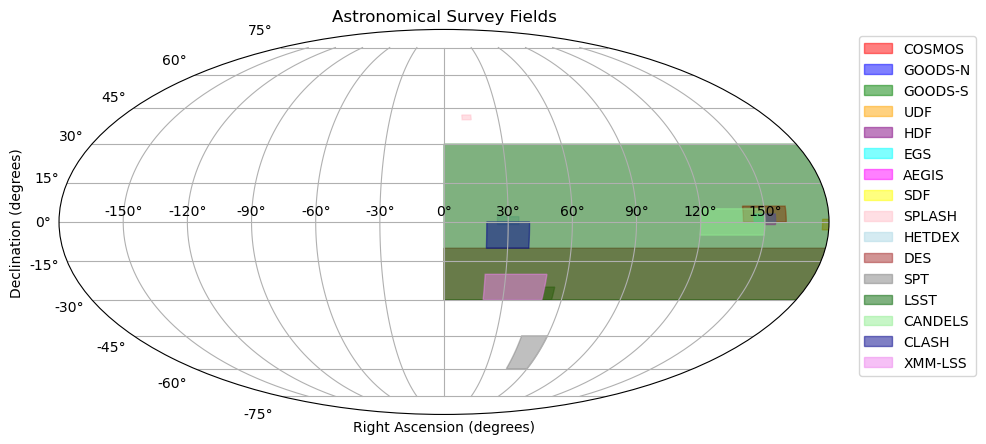

In [84]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

# Define survey fields and their approximate RA/Dec boundaries (degrees)
fields = {
    "COSMOS": [(140, 0), (160, 0), (160, 6), (140, 6)],
    "GOODS-N": [(185, 60), (195, 60), (195, 65), (185, 65)],
    "GOODS-S": [(50, -30), (55, -30), (55, -25), (50, -25)],
    "UDF": [(177, -3), (183, -3), (183, 1), (177, 1)],
    "HDF": [(185, 62), (195, 62), (195, 65), (185, 65)],
    "EGS": [(145, 0), (155, 0), (155, 3), (145, 3)],
    "AEGIS": [(150, -1), (155, -1), (155, 3), (150, 3)],
    "SDF": [(210, -30), (220, -30), (220, -25), (210, -25)],
    "SPLASH": [(10, 40), (15, 40), (15, 42), (10, 42)],
    "HETDEX": [(25, -1), (35, -1), (35, 2), (25, 2)],
    "DES": [(0, -30), (360, -30), (360, -10), (0, -10)],
    "SPT": [(45, -60), (60, -60), (60, -45), (45, -45)],
    "LSST": [(0, -30), (360, -30), (360, 30), (0, 30)],
    "CANDELS": [(120, -5), (150, -5), (150, 5), (120, 5)],
    "CLASH": [(20, -10), (40, -10), (40, 0), (20, 0)],
    "XMM-LSS": [(20, -30), (50, -30), (50, -20), (20, -20)],
}

# Define a color for each field
colors = {
    "COSMOS": "red",
    "GOODS-N": "blue",
    "GOODS-S": "green",
    "UDF": "orange",
    "HDF": "purple",
    "EGS": "cyan",
    "AEGIS": "magenta",
    "SDF": "yellow",
    "SPLASH": "pink",
    "HETDEX": "lightblue",
    "DES": "brown",
    "SPT": "gray",
    "LSST": "darkgreen",
    "CANDELS": "lightgreen",
    "CLASH": "darkblue",
    "XMM-LSS": "violet",
}

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={'projection': 'mollweide'})

# Set up the sky map
ax.set_xlabel("Right Ascension (degrees)")
ax.set_ylabel("Declination (degrees)")
ax.set_title("Astronomical Survey Fields")

# Plot each field with different colors
for field, coords in fields.items():
    polygon = Polygon(np.radians(coords), closed=True, alpha=0.5, color=colors[field], label=field)
    ax.add_patch(polygon)

# Add grid lines
ax.grid(True)

# Add legend
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1))

# Show the plot
plt.show()
